# Performance Tuning NLP BERT model Serving using Triton on SageMaker

This notebook demonstrates the use of Amazon SageMaker Inference recommender to perform custom load testing in order to performance fine tune the NLP BERT Model serving using NVIDIA Triton Serving on SageMaker.

[Amazon SageMaker](https://aws.amazon.com/sagemaker/) is a fully managed service for data science and machine learning workflows. It helps data scientists and developers to prepare, build, train, and deploy high-quality ML models quickly by bringing together a broad set of capabilities purpose-built for ML.

Now, [NVIDIA Triton Inference Server](https://github.com/triton-inference-server/server/) can be used to serve models for inference in Amazon SageMaker. Thanks to the new NVIDIA Triton container image, you can easily serve ML models and benefit from the performance optimizations, dynamic batching, and multi-framework support provided by NVIDIA Triton. Triton helps maximize the utilization of GPU and CPU, further lowering the cost of inference.

SageMaker Inference Recommender is a new capability of SageMaker that reduces the time required to get machine learning (ML) models in production by automating performance benchmarking and load testing models across SageMaker ML instances. You can use Inference Recommender to deploy your model to a real-time inference endpoint that delivers the best performance at the lowest cost.

This notebook was tested with the `conda_python3` kernel on an Amazon SageMaker notebook instance of type `g4dn`.

## Introduction to NVIDIA Triton Server

[NVIDIA Triton Inference Server](https://github.com/triton-inference-server/server/) was developed specifically to enable scalable, cost-effective, and easy deployment of models in production. NVIDIA Triton Inference Server is open-source inference serving software that simplifies the inference serving process and provides high inference performance.

Some key features of Triton are:
* **Support for Multiple frameworks**: Triton can be used to deploy models from all major frameworks. Triton supports TensorFlow GraphDef, TensorFlow SavedModel, ONNX, PyTorch TorchScript, TensorRT, RAPIDS FIL for tree based models, and OpenVINO model formats. 
* **Model pipelines**: Triton model ensemble represents a pipeline of one or more models or pre/post processing logic and the connection of input and output tensors between them. A single inference request to an ensemble will trigger the execution of the entire pipeline.
* **Concurrent model execution**: Multiple models (or multiple instances of the same model) can run simultaneously on the same GPU or on multiple GPUs for different model management needs.
* **Dynamic batching**: For models that support batching, Triton has multiple built-in scheduling and batching algorithms that combine individual inference requests together to improve inference throughput. These scheduling and batching decisions are transparent to the client requesting inference.
* **Diverse CPUs and GPUs**: The models can be executed on CPUs or GPUs for maximum flexibility and to support heterogeneous computing requirements.

**Note**: This initial release of NVIDIA Triton on SageMaker will only support a single model. Future releases will have multi-model support. A minimal `config.pbtxt` configuration file is **required** in the model artifacts. This release doesn't support inferring the model config automatically.

#### Install packages

Installs the dependencies required to package the model and run inferences using Triton server.

In [1]:
!pip install -qU pip awscli boto3 sagemaker transformers==4.9.1
!pip install nvidia-pyindex
!pip install tritonclient[http]

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 1.3.0 requires botocore<1.20.50,>=1.20.49, but you have botocore 1.24.37 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


#### Imports

In [2]:
# general imports
import boto3
import json
import os
import re
import copy
import time
from time import gmtime, strftime
import numpy as np
import datetime
import pprint
import pandas as pd

# sagemaker
import sagemaker
from sagemaker import get_execution_role

# triton
import tritonclient.http as httpclient

# transformers
from transformers import BertTokenizer

# custom cloudwatch
from cloudwatch import get_endpoint_metrics

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


#### Set Varaibles

We set SageMaker variables and other varibable below, also define the IAM role that will give Amazon SageMaker access to the model artifacts and the NVIDIA Triton ECR image.

In [3]:
# sagemaker
sess = boto3.Session()
sm = sess.client("sagemaker")
sagemaker_session = sagemaker.Session(boto_session=sess)
role = get_execution_role()
region = boto3.Session().region_name
bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/trt-triton-inference-recommender"

# boto clients
sm_client = boto3.client("sagemaker", region_name=region)
cw_client = boto3.client("cloudwatch", region)

account_id_map = {
    "us-east-1": "785573368785",
    "us-east-2": "007439368137",
    "us-west-1": "710691900526",
    "us-west-2": "301217895009",
    "eu-west-1": "802834080501",
    "eu-west-2": "205493899709",
    "eu-west-3": "254080097072",
    "eu-north-1": "601324751636",
    "eu-south-1": "966458181534",
    "eu-central-1": "746233611703",
    "ap-east-1": "110948597952",
    "ap-south-1": "763008648453",
    "ap-northeast-1": "941853720454",
    "ap-northeast-2": "151534178276",
    "ap-southeast-1": "324986816169",
    "ap-southeast-2": "355873309152",
    "cn-northwest-1": "474822919863",
    "cn-north-1": "472730292857",
    "sa-east-1": "756306329178",
    "ca-central-1": "464438896020",
    "me-south-1": "836785723513",
    "af-south-1": "774647643957",
}


if region not in account_id_map.keys():
    raise ("UNSUPPORTED REGION")

print(f"SageMaker Role: {role}")
print(f"Region Name: {region}")

SageMaker Role: arn:aws:iam::917092859813:role/service-role/viridian-sagemaker-notebook-SageMakerExecutionRole-1KL5F03PT23NN
Region Name: us-east-1


In [4]:
# local variables
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
sm_model_name = "trt-triton-benchmark-model-" + ts
model_package_group_name = "trt-triton-benchmark-model-group-" + ts
advanced_job = "trt-triton-benchmark-advanced-job-" + ts

print(f"SageMaker Model Name: {sm_model_name}")
print(f"SageMaker Mode Package Name: {model_package_group_name}")
print(f"SageMaker Advanced Job Name: {advanced_job}")

SageMaker Model Name: trt-triton-benchmark-model-2022-04-10-14-20-52
SageMaker Mode Package Name: trt-triton-benchmark-model-group-2022-04-10-14-20-52
SageMaker Advanced Job Name: trt-triton-benchmark-advanced-job-2022-04-10-14-20-52


#### Amazon SageMaker Triton Inference Server Deep Learning Container Image

Let's retrieve Amazon SageMaker NVIDIA Triton Inference server container image based on the account ID you are running this notebook.

Set `triton_image_uri` based on the `account_id` and `region` information

In [5]:
base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"
triton_image_uri = "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:21.08-py3".format(
    account_id=account_id_map[region], region=region, base=base
)

print(f"Triton Inference server DLC image: {triton_image_uri}")

Triton Inference server DLC image: 785573368785.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tritonserver:21.08-py3


## NLP Use case

Deploying and scaling NLP models in a production set up can be quite challenging. NLP models are often very large in size, containing millions of model parameters. Optimal model configurations are required to satisfy stringent performance and scalability of production grade NLP applications

In this notebook, we will benchmark a NLP use case using SageMaker Triton inference server and recommend performance tuning optimizations for the below NLP profile. We will use a large pre-trained transformer based `bert-large-uncased` model which has about 336 million model parameters. The input sentence used for the binary classification model will be padded and truncated to a maximum input sequence length 512 tokens. The inference load test will simulate to achieve 500 TPS (30000 maximum invocations per minute) and model latency of < 0.5 seconds (500 milliseconds)

## NVIDIA Triton Setup with Amazon SageMaker

1. We will use this [script](./workspace/generate_models.sh) to generate the TensorRT plan to be used with NVIDIA Triton inference server.
2. The script load the pre-trained `bert_large_uncased` model and saving it ONNX format can be found in this [location](./workspace/onnx_exporter.py)
3. Pre-trained model is loaded in torchscript format and model artifacts are saved used in onnx exporter(model.onnx)
4. trtexec is a tool to quickly utilize TensorRT without having to develop your own application. The trtexec tool has three main purposes:

    - benchmarking networks on random or user-provided input data.
    - generating serialized engines from models.
    - generating a serialized timing cache from the builder.


5. After trtexec execution is complete, model plan file(model_bs16.plan) is generated. This file will be used as model artifact by Triton
6. We used the pre-configured `config.pbtxt` file provided with this repo [here](./triton-serve-trt/bert/config.pbtxt) to specify model [configuration](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md) which Triton uses to load the model. 
7. We tar the model directory and upload it to s3 to later create a [SageMaker Model](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html).


**Note**: Amazon SageMaker expects the model tarball file to have a top level directory with the same name as the model defined in the `config.pbtxt`. Below is the sample model directory structure

```
bert
├── 1
│   └── model.plan
└── config.pbtxt
```

NOTE: The below script uses docker and thus will not work on Amazon SageMaker Studio notebook. Please use Amazon SageMaker Notebook instance to execute this notebook

#### CAUTION: TensoRT (TRT) is hardware-specific when it comes to compiling models for performance optimization. Therefore, the following cell should be run in as many different GPU-backed instance types as will be used in the load test. A separate load test should be run for each instance family (like g4, p3, etc..), so as to not try to load a model artifact that was compiled for one type of GPU onto another type of GPU.

This step is expected to run for ~15 minutes.

In [6]:
!docker run --gpus=all --rm -it \
            -v `pwd`/workspace:/workspace nvcr.io/nvidia/pytorch:21.08-py3 \
            /bin/bash generate_models.sh


== PyTorch ==

NVIDIA Release 21.08 (build 26011915)
PyTorch Version 1.10.0a0+3fd9dcf

Container image Copyright (c) 2021, NVIDIA CORPORATION.  All rights reserved.

Copyright (c) 2014-2021 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, Johnny Mariethoz)
Copyright (c) 2015      Google Inc.
Copyright (c) 2015      Yangqing Jia
Copyright (c) 2013-2016 The Caffe contributors
All rights reserved.

NVIDIA Deep Learning Profiler (dlprof) Copyright (c) 2021, NVIDIA CORPORATION.  All rights reserved.

Various fil

[04/10/2022-14:21:55] [I] === Device Information ===
[04/10/2022-14:21:55] [I] Selected Device: Tesla T4
[04/10/2022-14:21:55] [I] Compute Capability: 7.5
[04/10/2022-14:21:55] [I] SMs: 40
[04/10/2022-14:21:55] [I] Compute Clock Rate: 1.59 GHz
[04/10/2022-14:21:55] [I] Device Global Memory: 15109 MiB
[04/10/2022-14:21:55] [I] Shared Memory per SM: 64 KiB
[04/10/2022-14:21:55] [I] Memory Bus Width: 256 bits (ECC enabled)
[04/10/2022-14:21:55] [I] Memory Clock Rate: 5.001 GHz
[04/10/2022-14:21:55] [I] 
[04/10/2022-14:21:55] [I] TensorRT version: 8001
[04/10/2022-14:21:55] [V] [TRT] Registered plugin creator - ::GridAnchor_TRT version 1
[04/10/2022-14:21:55] [V] [TRT] Registered plugin creator - ::GridAnchorRect_TRT version 1
[04/10/2022-14:21:55] [V] [TRT] Registered plugin creator - ::NMS_TRT version 1
[04/10/2022-14:21:55] [V] [TRT] Registered plugin creator - ::Reorg_TRT version 1
[04/10/2022-14:21:55] [V] [TRT] Registered plugin creator - ::Region_TRT version 1
[04/10/2022-14:21:55] 

[04/10/2022-14:21:58] [V] [TRT] Registering tensor: 557 for ONNX tensor: 557
[04/10/2022-14:21:58] [V] [TRT] Add_135 [Add] outputs: [557 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:58] [V] [TRT] Parsing node: ReduceMean_136 [ReduceMean]
[04/10/2022-14:21:58] [V] [TRT] Searching for input: 557
[04/10/2022-14:21:58] [V] [TRT] ReduceMean_136 [ReduceMean] inputs: [557 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:58] [V] [TRT] Registering layer: ReduceMean_136 for ONNX node: ReduceMean_136
[04/10/2022-14:21:58] [V] [TRT] Registering tensor: 558 for ONNX tensor: 558
[04/10/2022-14:21:58] [V] [TRT] ReduceMean_136 [ReduceMean] outputs: [558 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:21:58] [V] [TRT] Parsing node: Sub_137 [Sub]
[04/10/2022-14:21:58] [V] [TRT] Searching for input: 557
[04/10/2022-14:21:58] [V] [TRT] Searching for input: 558
[04/10/2022-14:21:58] [V] [TRT] Sub_137 [Sub] inputs: [557 -> (-1, -1, 1024)[FLOAT]], [558 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:21:58] [V] [TRT] Registeri

[04/10/2022-14:21:58] [V] [TRT] Registering layer: Add_256 for ONNX node: Add_256
[04/10/2022-14:21:58] [V] [TRT] Registering tensor: 705 for ONNX tensor: 705
[04/10/2022-14:21:58] [V] [TRT] Add_256 [Add] outputs: [705 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:58] [V] [TRT] Parsing node: Shape_257 [Shape]
[04/10/2022-14:21:58] [V] [TRT] Searching for input: 705
[04/10/2022-14:21:58] [V] [TRT] Shape_257 [Shape] inputs: [705 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:58] [V] [TRT] Registering layer: Shape_257 for ONNX node: Shape_257
[04/10/2022-14:21:58] [V] [TRT] Registering tensor: 706 for ONNX tensor: 706
[04/10/2022-14:21:58] [V] [TRT] Shape_257 [Shape] outputs: [706 -> (3)[INT32]], 
[04/10/2022-14:21:58] [V] [TRT] Parsing node: Constant_258 [Constant]
[04/10/2022-14:21:58] [V] [TRT] Constant_258 [Constant] inputs: 
[04/10/2022-14:21:58] [V] [TRT] Constant_258 [Constant] outputs: [707 -> ()[INT32]], 
[04/10/2022-14:21:58] [V] [TRT] Parsing node: Gather_259 [Gather]
[04/10/202

[04/10/2022-14:21:58] [V] [TRT] Registering tensor: 806 for ONNX tensor: 806
[04/10/2022-14:21:58] [V] [TRT] Shape_342 [Shape] outputs: [806 -> (3)[INT32]], 
[04/10/2022-14:21:58] [V] [TRT] Parsing node: Constant_343 [Constant]
[04/10/2022-14:21:58] [V] [TRT] Constant_343 [Constant] inputs: 
[04/10/2022-14:21:58] [V] [TRT] Constant_343 [Constant] outputs: [807 -> ()[INT32]], 
[04/10/2022-14:21:58] [V] [TRT] Parsing node: Gather_344 [Gather]
[04/10/2022-14:21:58] [V] [TRT] Searching for input: 806
[04/10/2022-14:21:58] [V] [TRT] Searching for input: 807
[04/10/2022-14:21:58] [V] [TRT] Gather_344 [Gather] inputs: [806 -> (3)[INT32]], [807 -> ()[INT32]], 
[04/10/2022-14:21:58] [V] [TRT] Registering layer: 807 for ONNX node: 807
[04/10/2022-14:21:58] [V] [TRT] Using Gather axis: 0
[04/10/2022-14:21:58] [V] [TRT] Registering layer: Gather_344 for ONNX node: Gather_344
[04/10/2022-14:21:58] [V] [TRT] Registering tensor: 808 for ONNX tensor: 808
[04/10/2022-14:21:58] [V] [TRT] Gather_344 [Gat

[04/10/2022-14:21:58] [V] [TRT] Registering layer: Mul_414 for ONNX node: Mul_414
[04/10/2022-14:21:58] [V] [TRT] Registering tensor: 895 for ONNX tensor: 895
[04/10/2022-14:21:58] [V] [TRT] Mul_414 [Mul] outputs: [895 -> (-1, -1, 4096)[FLOAT]], 
[04/10/2022-14:21:58] [V] [TRT] Parsing node: MatMul_415 [MatMul]
[04/10/2022-14:21:58] [V] [TRT] Searching for input: 895
[04/10/2022-14:21:58] [V] [TRT] Searching for input: 3250
[04/10/2022-14:21:58] [V] [TRT] MatMul_415 [MatMul] inputs: [895 -> (-1, -1, 4096)[FLOAT]], [3250 -> (4096, 1024)[FLOAT]], 
[04/10/2022-14:21:58] [V] [TRT] Registering layer: 3250 for ONNX node: 3250
[04/10/2022-14:21:58] [V] [TRT] Registering layer: MatMul_415 for ONNX node: MatMul_415
[04/10/2022-14:21:58] [V] [TRT] Registering tensor: 897 for ONNX tensor: 897
[04/10/2022-14:21:58] [V] [TRT] MatMul_415 [MatMul] outputs: [897 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:58] [V] [TRT] Parsing node: Add_416 [Add]
[04/10/2022-14:21:58] [V] [TRT] Searching for input: 

[04/10/2022-14:21:58] [V] [TRT] Registering tensor: 969 for ONNX tensor: 969
[04/10/2022-14:21:58] [V] [TRT] Softmax_472 [Softmax] outputs: [969 -> (-1, 16, -1, -1)[FLOAT]], 
[04/10/2022-14:21:58] [V] [TRT] Parsing node: MatMul_473 [MatMul]
[04/10/2022-14:21:58] [V] [TRT] Searching for input: 969
[04/10/2022-14:21:58] [V] [TRT] Searching for input: 948
[04/10/2022-14:21:58] [V] [TRT] MatMul_473 [MatMul] inputs: [969 -> (-1, 16, -1, -1)[FLOAT]], [948 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:21:58] [V] [TRT] Registering layer: MatMul_473 for ONNX node: MatMul_473
[04/10/2022-14:21:58] [V] [TRT] Registering tensor: 970 for ONNX tensor: 970
[04/10/2022-14:21:58] [V] [TRT] MatMul_473 [MatMul] outputs: [970 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:21:58] [V] [TRT] Parsing node: Transpose_474 [Transpose]
[04/10/2022-14:21:58] [V] [TRT] Searching for input: 970
[04/10/2022-14:21:58] [V] [TRT] Transpose_474 [Transpose] inputs: [970 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:21:58] [V]

[04/10/2022-14:21:59] [V] [TRT] Registering layer: Add_524 for ONNX node: Add_524
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1027 for ONNX tensor: 1027
[04/10/2022-14:21:59] [V] [TRT] Add_524 [Add] outputs: [1027 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: MatMul_525 [MatMul]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1024
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 3265
[04/10/2022-14:21:59] [V] [TRT] MatMul_525 [MatMul] inputs: [1024 -> (-1, -1, 1024)[FLOAT]], [3265 -> (1024, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: 3265 for ONNX node: 3265
[04/10/2022-14:21:59] [V] [TRT] Registering layer: MatMul_525 for ONNX node: MatMul_525
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1029 for ONNX tensor: 1029
[04/10/2022-14:21:59] [V] [TRT] MatMul_525 [MatMul] outputs: [1029 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Add_526 [Add]
[04/10/2022-14:21:59] [V] [TRT] Searching for

[04/10/2022-14:21:59] [V] [TRT] Using Gather axis: 0
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Gather_574 for ONNX node: Gather_574
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1091 for ONNX tensor: 1091
[04/10/2022-14:21:59] [V] [TRT] Gather_574 [Gather] outputs: [1091 -> ()[INT32]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Unsqueeze_575 [Unsqueeze]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1088
[04/10/2022-14:21:59] [V] [TRT] Unsqueeze_575 [Unsqueeze] inputs: [1088 -> ()[INT32]], 
[04/10/2022-14:21:59] [V] [TRT] Original shape: (), unsqueezing to: (1,)
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Unsqueeze_575 for ONNX node: Unsqueeze_575
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1093 for ONNX tensor: 1093
[04/10/2022-14:21:59] [V] [TRT] Unsqueeze_575 [Unsqueeze] outputs: [1093 -> (1)[INT32]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Unsqueeze_576 [Unsqueeze]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1091
[04/10/2022-1

[04/10/2022-14:21:59] [V] [TRT] Registering layer: MatMul_617 for ONNX node: MatMul_617
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1140 for ONNX tensor: 1140
[04/10/2022-14:21:59] [V] [TRT] MatMul_617 [MatMul] outputs: [1140 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Add_618 [Add]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: encoder.layer.6.attention.self.query.bias
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1140
[04/10/2022-14:21:59] [V] [TRT] Add_618 [Add] inputs: [encoder.layer.6.attention.self.query.bias -> (1024)[FLOAT]], [1140 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: encoder.layer.6.attention.self.query.bias for ONNX node: encoder.layer.6.attention.self.query.bias
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Add_618 for ONNX node: Add_618
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1141 for ONNX tensor: 1141
[04/10/2022-14:21:59] [V] [TRT] Add_618 [Add] outputs: [1141 -> 

[04/10/2022-14:21:59] [V] [TRT] Registering layer: Softmax_660 for ONNX node: Softmax_660
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1197 for ONNX tensor: 1197
[04/10/2022-14:21:59] [V] [TRT] Softmax_660 [Softmax] outputs: [1197 -> (-1, 16, -1, -1)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: MatMul_661 [MatMul]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1197
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1176
[04/10/2022-14:21:59] [V] [TRT] MatMul_661 [MatMul] inputs: [1197 -> (-1, 16, -1, -1)[FLOAT]], [1176 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: MatMul_661 for ONNX node: MatMul_661
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1198 for ONNX tensor: 1198
[04/10/2022-14:21:59] [V] [TRT] MatMul_661 [MatMul] outputs: [1198 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Transpose_662 [Transpose]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1198
[04/10/2022-14:21:59] [V]

[04/10/2022-14:21:59] [V] [TRT] Registering layer: encoder.layer.6.output.dense.bias for ONNX node: encoder.layer.6.output.dense.bias
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Add_698 for ONNX node: Add_698
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1240 for ONNX tensor: 1240
[04/10/2022-14:21:59] [V] [TRT] Add_698 [Add] outputs: [1240 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Add_699 [Add]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1240
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1226
[04/10/2022-14:21:59] [V] [TRT] Add_699 [Add] inputs: [1240 -> (-1, -1, 1024)[FLOAT]], [1226 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Add_699 for ONNX node: Add_699
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1241 for ONNX tensor: 1241
[04/10/2022-14:21:59] [V] [TRT] Add_699 [Add] outputs: [1241 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: ReduceMean_700 [ReduceM

[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1289 for ONNX tensor: 1289
[04/10/2022-14:21:59] [V] [TRT] Reshape_736 [Reshape] outputs: [1289 -> (-1, -1, 16, 64)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Transpose_737 [Transpose]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1289
[04/10/2022-14:21:59] [V] [TRT] Transpose_737 [Transpose] inputs: [1289 -> (-1, -1, 16, 64)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Transpose_737 for ONNX node: Transpose_737
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1290 for ONNX tensor: 1290
[04/10/2022-14:21:59] [V] [TRT] Transpose_737 [Transpose] outputs: [1290 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Shape_738 [Shape]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1255
[04/10/2022-14:21:59] [V] [TRT] Shape_738 [Shape] inputs: [1255 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Shape_738 for ONNX node: Shape_738
[04/10/2022-14

[04/10/2022-14:21:59] [V] [TRT] Registering layer: ReduceMean_770 for ONNX node: ReduceMean_770
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1330 for ONNX tensor: 1330
[04/10/2022-14:21:59] [V] [TRT] ReduceMean_770 [ReduceMean] outputs: [1330 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Sub_771 [Sub]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1329
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1330
[04/10/2022-14:21:59] [V] [TRT] Sub_771 [Sub] inputs: [1329 -> (-1, -1, 1024)[FLOAT]], [1330 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Sub_771 for ONNX node: Sub_771
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1331 for ONNX tensor: 1331
[04/10/2022-14:21:59] [V] [TRT] Sub_771 [Sub] outputs: [1331 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Constant_772 [Constant]
[04/10/2022-14:21:59] [V] [TRT] Constant_772 [Constant] inputs: 
[04/10/2022-14:21:59] [V] [TRT] Constant_772 [

[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1366 for ONNX tensor: 1366
[04/10/2022-14:21:59] [V] [TRT] Add_804 [Add] outputs: [1366 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: MatMul_805 [MatMul]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1366
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 3303
[04/10/2022-14:21:59] [V] [TRT] MatMul_805 [MatMul] inputs: [1366 -> (-1, -1, 1024)[FLOAT]], [3303 -> (1024, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: 3303 for ONNX node: 3303
[04/10/2022-14:21:59] [V] [TRT] Registering layer: MatMul_805 for ONNX node: MatMul_805
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1368 for ONNX tensor: 1368
[04/10/2022-14:21:59] [V] [TRT] MatMul_805 [MatMul] outputs: [1368 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Add_806 [Add]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: encoder.layer.8.attention.self.query.bias
[04/10/2022-14:21:59] [V] [TRT] 

[04/10/2022-14:21:59] [V] [TRT] Registering layer: Concat_840 for ONNX node: Concat_840
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1417 for ONNX tensor: 1417
[04/10/2022-14:21:59] [V] [TRT] Concat_840 [Concat] outputs: [1417 -> (4)[INT32]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Reshape_841 [Reshape]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1369
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1417
[04/10/2022-14:21:59] [V] [TRT] Reshape_841 [Reshape] inputs: [1369 -> (-1, -1, 1024)[FLOAT]], [1417 -> (4)[INT32]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Reshape_841 for ONNX node: Reshape_841
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1418 for ONNX tensor: 1418
[04/10/2022-14:21:59] [V] [TRT] Reshape_841 [Reshape] outputs: [1418 -> (-1, -1, 16, 64)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Transpose_842 [Transpose]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1418
[04/10/2022-14:21:59] [V] [TRT] Transpose_842 [Tr

[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1448 for ONNX tensor: 1448
[04/10/2022-14:21:59] [V] [TRT] ReduceMean_868 [ReduceMean] outputs: [1448 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Constant_869 [Constant]
[04/10/2022-14:21:59] [V] [TRT] Constant_869 [Constant] inputs: 
[04/10/2022-14:21:59] [V] [TRT] Constant_869 [Constant] outputs: [1449 -> ()[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Add_870 [Add]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1448
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1449
[04/10/2022-14:21:59] [V] [TRT] Add_870 [Add] inputs: [1448 -> (-1, -1, 1)[FLOAT]], [1449 -> ()[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: 1449 for ONNX node: 1449
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Add_870 for ONNX node: Add_870
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1450 for ONNX tensor: 1450
[04/10/2022-14:21:59] [V] [TRT] Add_870 [Add] outputs: [1450 -> (-1, -1, 1)[FLOA

[04/10/2022-14:21:59] [V] [TRT] Registering layer: Add_898 for ONNX node: Add_898
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1480 for ONNX tensor: 1480
[04/10/2022-14:21:59] [V] [TRT] Add_898 [Add] outputs: [1480 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: MatMul_899 [MatMul]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1480
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 3316
[04/10/2022-14:21:59] [V] [TRT] MatMul_899 [MatMul] inputs: [1480 -> (-1, -1, 1024)[FLOAT]], [3316 -> (1024, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: 3316 for ONNX node: 3316
[04/10/2022-14:21:59] [V] [TRT] Registering layer: MatMul_899 for ONNX node: MatMul_899
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1482 for ONNX tensor: 1482
[04/10/2022-14:21:59] [V] [TRT] MatMul_899 [MatMul] outputs: [1482 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Add_900 [Add]
[04/10/2022-14:21:59] [V] [TRT] Searching for

[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1521 for ONNX tensor: 1521
[04/10/2022-14:21:59] [V] [TRT] Gather_928 [Gather] outputs: [1521 -> ()[INT32]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Shape_929 [Shape]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1483
[04/10/2022-14:21:59] [V] [TRT] Shape_929 [Shape] inputs: [1483 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Shape_929 for ONNX node: Shape_929
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1522 for ONNX tensor: 1522
[04/10/2022-14:21:59] [V] [TRT] Shape_929 [Shape] outputs: [1522 -> (3)[INT32]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Constant_930 [Constant]
[04/10/2022-14:21:59] [V] [TRT] Constant_930 [Constant] inputs: 
[04/10/2022-14:21:59] [V] [TRT] Constant_930 [Constant] outputs: [1523 -> ()[INT32]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Gather_931 [Gather]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1522
[04/10/2022-14:21:59] [V] [TRT]

[04/10/2022-14:21:59] [V] [TRT] Registering layer: MatMul_955 for ONNX node: MatMul_955
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1555 for ONNX tensor: 1555
[04/10/2022-14:21:59] [V] [TRT] MatMul_955 [MatMul] outputs: [1555 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Add_956 [Add]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: encoder.layer.9.attention.output.dense.bias
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1555
[04/10/2022-14:21:59] [V] [TRT] Add_956 [Add] inputs: [encoder.layer.9.attention.output.dense.bias -> (1024)[FLOAT]], [1555 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: encoder.layer.9.attention.output.dense.bias for ONNX node: encoder.layer.9.attention.output.dense.bias
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Add_956 for ONNX node: Add_956
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1556 for ONNX tensor: 1556
[04/10/2022-14:21:59] [V] [TRT] Add_956 [Add] outputs: [

[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1584 for ONNX tensor: 1584
[04/10/2022-14:21:59] [V] [TRT] ReduceMean_982 [ReduceMean] outputs: [1584 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Sub_983 [Sub]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1583
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1584
[04/10/2022-14:21:59] [V] [TRT] Sub_983 [Sub] inputs: [1583 -> (-1, -1, 1024)[FLOAT]], [1584 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Sub_983 for ONNX node: Sub_983
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1585 for ONNX tensor: 1585
[04/10/2022-14:21:59] [V] [TRT] Sub_983 [Sub] outputs: [1585 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Constant_984 [Constant]
[04/10/2022-14:21:59] [V] [TRT] Constant_984 [Constant] inputs: 
[04/10/2022-14:21:59] [V] [TRT] Constant_984 [Constant] outputs: [1586 -> ()[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Pow_985 [

[04/10/2022-14:21:59] [V] [TRT] Registering layer: Add_1008 for ONNX node: Add_1008
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1617 for ONNX tensor: 1617
[04/10/2022-14:21:59] [V] [TRT] Add_1008 [Add] outputs: [1617 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Shape_1009 [Shape]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1617
[04/10/2022-14:21:59] [V] [TRT] Shape_1009 [Shape] inputs: [1617 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Shape_1009 for ONNX node: Shape_1009
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1618 for ONNX tensor: 1618
[04/10/2022-14:21:59] [V] [TRT] Shape_1009 [Shape] outputs: [1618 -> (3)[INT32]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Constant_1010 [Constant]
[04/10/2022-14:21:59] [V] [TRT] Constant_1010 [Constant] inputs: 
[04/10/2022-14:21:59] [V] [TRT] Constant_1010 [Constant] outputs: [1619 -> ()[INT32]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Gather_101

[04/10/2022-14:21:59] [V] [TRT] Registering layer: Softmax_1036 for ONNX node: Softmax_1036
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1653 for ONNX tensor: 1653
[04/10/2022-14:21:59] [V] [TRT] Softmax_1036 [Softmax] outputs: [1653 -> (-1, 16, -1, -1)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: MatMul_1037 [MatMul]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1653
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1632
[04/10/2022-14:21:59] [V] [TRT] MatMul_1037 [MatMul] inputs: [1653 -> (-1, 16, -1, -1)[FLOAT]], [1632 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: MatMul_1037 for ONNX node: MatMul_1037
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1654 for ONNX tensor: 1654
[04/10/2022-14:21:59] [V] [TRT] MatMul_1037 [MatMul] outputs: [1654 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Transpose_1038 [Transpose]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1654
[04/10/2022-14:2

[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1681 for ONNX tensor: 1681
[04/10/2022-14:21:59] [V] [TRT] Mul_1061 [Mul] outputs: [1681 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Add_1062 [Add]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1681
[04/10/2022-14:21:59] [V] [TRT] Searching for input: encoder.layer.10.attention.output.LayerNorm.bias
[04/10/2022-14:21:59] [V] [TRT] Add_1062 [Add] inputs: [1681 -> (-1, -1, 1024)[FLOAT]], [encoder.layer.10.attention.output.LayerNorm.bias -> (1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: encoder.layer.10.attention.output.LayerNorm.bias for ONNX node: encoder.layer.10.attention.output.LayerNorm.bias
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Add_1062 for ONNX node: Add_1062
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1682 for ONNX tensor: 1682
[04/10/2022-14:21:59] [V] [TRT] Add_1062 [Add] outputs: [1682 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Par

[04/10/2022-14:21:59] [V] [TRT] Registering layer: Add_1086 for ONNX node: Add_1086
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1708 for ONNX tensor: 1708
[04/10/2022-14:21:59] [V] [TRT] Add_1086 [Add] outputs: [1708 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: MatMul_1087 [MatMul]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1708
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 3342
[04/10/2022-14:21:59] [V] [TRT] MatMul_1087 [MatMul] inputs: [1708 -> (-1, -1, 1024)[FLOAT]], [3342 -> (1024, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: 3342 for ONNX node: 3342
[04/10/2022-14:21:59] [V] [TRT] Registering layer: MatMul_1087 for ONNX node: MatMul_1087
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1710 for ONNX tensor: 1710
[04/10/2022-14:21:59] [V] [TRT] MatMul_1087 [MatMul] outputs: [1710 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Add_1088 [Add]
[04/10/2022-14:21:59] [V] [TRT] Sear

[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1740 for ONNX tensor: 1740
[04/10/2022-14:21:59] [V] [TRT] Unsqueeze_1109 [Unsqueeze] outputs: [1740 -> (1)[INT32]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Unsqueeze_1110 [Unsqueeze]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1737
[04/10/2022-14:21:59] [V] [TRT] Unsqueeze_1110 [Unsqueeze] inputs: [1737 -> ()[INT32]], 
[04/10/2022-14:21:59] [V] [TRT] Original shape: (), unsqueezing to: (1,)
[04/10/2022-14:21:59] [V] [TRT] Registering layer: Unsqueeze_1110 for ONNX node: Unsqueeze_1110
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1741 for ONNX tensor: 1741
[04/10/2022-14:21:59] [V] [TRT] Unsqueeze_1110 [Unsqueeze] outputs: [1741 -> (1)[INT32]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Concat_1111 [Concat]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1740
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1741
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 3347
[04/10/2022-14:21:59] [V] [TRT

[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1767 for ONNX tensor: 1767
[04/10/2022-14:21:59] [V] [TRT] Softmax_1130 [Softmax] outputs: [1767 -> (-1, 16, -1, -1)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: MatMul_1131 [MatMul]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1767
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1746
[04/10/2022-14:21:59] [V] [TRT] MatMul_1131 [MatMul] inputs: [1767 -> (-1, 16, -1, -1)[FLOAT]], [1746 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Registering layer: MatMul_1131 for ONNX node: MatMul_1131
[04/10/2022-14:21:59] [V] [TRT] Registering tensor: 1768 for ONNX tensor: 1768
[04/10/2022-14:21:59] [V] [TRT] MatMul_1131 [MatMul] outputs: [1768 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:21:59] [V] [TRT] Parsing node: Transpose_1132 [Transpose]
[04/10/2022-14:21:59] [V] [TRT] Searching for input: 1768
[04/10/2022-14:21:59] [V] [TRT] Transpose_1132 [Transpose] inputs: [1768 -> (-1, 16, -1, 64)[FLOAT]], 
[04/1

[04/10/2022-14:22:00] [V] [TRT] Registering layer: Add_1156 for ONNX node: Add_1156
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1796 for ONNX tensor: 1796
[04/10/2022-14:22:00] [V] [TRT] Add_1156 [Add] outputs: [1796 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: MatMul_1157 [MatMul]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 1796
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 3353
[04/10/2022-14:22:00] [V] [TRT] MatMul_1157 [MatMul] inputs: [1796 -> (-1, -1, 1024)[FLOAT]], [3353 -> (1024, 4096)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Registering layer: 3353 for ONNX node: 3353
[04/10/2022-14:22:00] [V] [TRT] Registering layer: MatMul_1157 for ONNX node: MatMul_1157
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1798 for ONNX tensor: 1798
[04/10/2022-14:22:00] [V] [TRT] MatMul_1157 [MatMul] outputs: [1798 -> (-1, -1, 4096)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Add_1158 [Add]
[04/10/2022-14:22:00] [V] [TRT] Sear

[04/10/2022-14:22:00] [V] [TRT] Registering layer: Mul_1179 for ONNX node: Mul_1179
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1821 for ONNX tensor: 1821
[04/10/2022-14:22:00] [V] [TRT] Mul_1179 [Mul] outputs: [1821 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Add_1180 [Add]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 1821
[04/10/2022-14:22:00] [V] [TRT] Searching for input: encoder.layer.11.output.LayerNorm.bias
[04/10/2022-14:22:00] [V] [TRT] Add_1180 [Add] inputs: [1821 -> (-1, -1, 1024)[FLOAT]], [encoder.layer.11.output.LayerNorm.bias -> (1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Registering layer: encoder.layer.11.output.LayerNorm.bias for ONNX node: encoder.layer.11.output.LayerNorm.bias
[04/10/2022-14:22:00] [V] [TRT] Registering layer: Add_1180 for ONNX node: Add_1180
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1822 for ONNX tensor: 1822
[04/10/2022-14:22:00] [V] [TRT] Add_1180 [Add] outputs: [1822 -> (-1, -1, 1024)[F

[04/10/2022-14:22:00] [V] [TRT] Using Gather axis: 0
[04/10/2022-14:22:00] [V] [TRT] Registering layer: Gather_1199 for ONNX node: Gather_1199
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1848 for ONNX tensor: 1848
[04/10/2022-14:22:00] [V] [TRT] Gather_1199 [Gather] outputs: [1848 -> ()[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Shape_1200 [Shape]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 1845
[04/10/2022-14:22:00] [V] [TRT] Shape_1200 [Shape] inputs: [1845 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Registering layer: Shape_1200 for ONNX node: Shape_1200
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1849 for ONNX tensor: 1849
[04/10/2022-14:22:00] [V] [TRT] Shape_1200 [Shape] outputs: [1849 -> (3)[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Constant_1201 [Constant]
[04/10/2022-14:22:00] [V] [TRT] Constant_1201 [Constant] inputs: 
[04/10/2022-14:22:00] [V] [TRT] Constant_1201 [Constant] outputs: [1850 -> ()[INT32]], 
[04

[04/10/2022-14:22:00] [V] [TRT] Registering layer: Softmax_1224 for ONNX node: Softmax_1224
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1881 for ONNX tensor: 1881
[04/10/2022-14:22:00] [V] [TRT] Softmax_1224 [Softmax] outputs: [1881 -> (-1, 16, -1, -1)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: MatMul_1225 [MatMul]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 1881
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 1860
[04/10/2022-14:22:00] [V] [TRT] MatMul_1225 [MatMul] inputs: [1881 -> (-1, 16, -1, -1)[FLOAT]], [1860 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Registering layer: MatMul_1225 for ONNX node: MatMul_1225
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1882 for ONNX tensor: 1882
[04/10/2022-14:22:00] [V] [TRT] MatMul_1225 [MatMul] outputs: [1882 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Transpose_1226 [Transpose]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 1882
[04/10/2022-14:2

[04/10/2022-14:22:00] [V] [TRT] Registering layer: Pow_1243 for ONNX node: Pow_1243
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1903 for ONNX tensor: 1903
[04/10/2022-14:22:00] [V] [TRT] Pow_1243 [Pow] outputs: [1903 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: ReduceMean_1244 [ReduceMean]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 1903
[04/10/2022-14:22:00] [V] [TRT] ReduceMean_1244 [ReduceMean] inputs: [1903 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Registering layer: ReduceMean_1244 for ONNX node: ReduceMean_1244
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1904 for ONNX tensor: 1904
[04/10/2022-14:22:00] [V] [TRT] ReduceMean_1244 [ReduceMean] outputs: [1904 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Constant_1245 [Constant]
[04/10/2022-14:22:00] [V] [TRT] Constant_1245 [Constant] inputs: 
[04/10/2022-14:22:00] [V] [TRT] Constant_1245 [Constant] outputs: [1905 -> ()[FLOAT]], 
[04/10/2

[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1924 for ONNX tensor: 1924
[04/10/2022-14:22:00] [V] [TRT] Add_1262 [Add] outputs: [1924 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Add_1263 [Add]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 1924
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 1910
[04/10/2022-14:22:00] [V] [TRT] Add_1263 [Add] inputs: [1924 -> (-1, -1, 1024)[FLOAT]], [1910 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Registering layer: Add_1263 for ONNX node: Add_1263
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1925 for ONNX tensor: 1925
[04/10/2022-14:22:00] [V] [TRT] Add_1263 [Add] outputs: [1925 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: ReduceMean_1264 [ReduceMean]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 1925
[04/10/2022-14:22:00] [V] [TRT] ReduceMean_1264 [ReduceMean] inputs: [1925 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Registering

[04/10/2022-14:22:00] [V] [TRT] Using Gather axis: 0
[04/10/2022-14:22:00] [V] [TRT] Registering layer: Gather_1284 for ONNX node: Gather_1284
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1948 for ONNX tensor: 1948
[04/10/2022-14:22:00] [V] [TRT] Gather_1284 [Gather] outputs: [1948 -> ()[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Unsqueeze_1285 [Unsqueeze]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 1945
[04/10/2022-14:22:00] [V] [TRT] Unsqueeze_1285 [Unsqueeze] inputs: [1945 -> ()[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Original shape: (), unsqueezing to: (1,)
[04/10/2022-14:22:00] [V] [TRT] Registering layer: Unsqueeze_1285 for ONNX node: Unsqueeze_1285
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1951 for ONNX tensor: 1951
[04/10/2022-14:22:00] [V] [TRT] Unsqueeze_1285 [Unsqueeze] outputs: [1951 -> (1)[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Unsqueeze_1286 [Unsqueeze]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 1948
[04/

[04/10/2022-14:22:00] [V] [TRT] Using Gather axis: 0
[04/10/2022-14:22:00] [V] [TRT] Registering layer: Gather_1307 for ONNX node: Gather_1307
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1980 for ONNX tensor: 1980
[04/10/2022-14:22:00] [V] [TRT] Gather_1307 [Gather] outputs: [1980 -> ()[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Unsqueeze_1308 [Unsqueeze]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 1977
[04/10/2022-14:22:00] [V] [TRT] Unsqueeze_1308 [Unsqueeze] inputs: [1977 -> ()[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Original shape: (), unsqueezing to: (1,)
[04/10/2022-14:22:00] [V] [TRT] Registering layer: Unsqueeze_1308 for ONNX node: Unsqueeze_1308
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 1983 for ONNX tensor: 1983
[04/10/2022-14:22:00] [V] [TRT] Unsqueeze_1308 [Unsqueeze] outputs: [1983 -> (1)[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Unsqueeze_1309 [Unsqueeze]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 1980
[04/

[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2000 for ONNX tensor: 2000
[04/10/2022-14:22:00] [V] [TRT] Gather_1323 [Gather] outputs: [2000 -> ()[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Shape_1324 [Shape]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 1997
[04/10/2022-14:22:00] [V] [TRT] Shape_1324 [Shape] inputs: [1997 -> (-1, -1, 16, 64)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Registering layer: Shape_1324 for ONNX node: Shape_1324
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2001 for ONNX tensor: 2001
[04/10/2022-14:22:00] [V] [TRT] Shape_1324 [Shape] outputs: [2001 -> (4)[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Constant_1325 [Constant]
[04/10/2022-14:22:00] [V] [TRT] Constant_1325 [Constant] inputs: 
[04/10/2022-14:22:00] [V] [TRT] Constant_1325 [Constant] outputs: [2002 -> ()[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Gather_1326 [Gather]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2001
[04/10/2022-14:22:0

[04/10/2022-14:22:00] [V] [TRT] Registering layer: Add_1344 for ONNX node: Add_1344
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2024 for ONNX tensor: 2024
[04/10/2022-14:22:00] [V] [TRT] Add_1344 [Add] outputs: [2024 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: MatMul_1345 [MatMul]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2024
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 3379
[04/10/2022-14:22:00] [V] [TRT] MatMul_1345 [MatMul] inputs: [2024 -> (-1, -1, 1024)[FLOAT]], [3379 -> (1024, 4096)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Registering layer: 3379 for ONNX node: 3379
[04/10/2022-14:22:00] [V] [TRT] Registering layer: MatMul_1345 for ONNX node: MatMul_1345
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2026 for ONNX tensor: 2026
[04/10/2022-14:22:00] [V] [TRT] MatMul_1345 [MatMul] outputs: [2026 -> (-1, -1, 4096)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Add_1346 [Add]
[04/10/2022-14:22:00] [V] [TRT] Sear

[04/10/2022-14:22:00] [V] [TRT] Registering layer: Add_1364 for ONNX node: Add_1364
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2046 for ONNX tensor: 2046
[04/10/2022-14:22:00] [V] [TRT] Add_1364 [Add] outputs: [2046 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Sqrt_1365 [Sqrt]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2046
[04/10/2022-14:22:00] [V] [TRT] Sqrt_1365 [Sqrt] inputs: [2046 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Registering layer: Sqrt_1365 for ONNX node: Sqrt_1365
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2047 for ONNX tensor: 2047
[04/10/2022-14:22:00] [V] [TRT] Sqrt_1365 [Sqrt] outputs: [2047 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Div_1366 [Div]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2041
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2047
[04/10/2022-14:22:00] [V] [TRT] Div_1366 [Div] inputs: [2041 -> (-1, -1, 1024)[FLOAT]], [2047 -> (-1, -1, 1)[F

[04/10/2022-14:22:00] [V] [TRT] Registering layer: Reshape_1382 for ONNX node: Reshape_1382
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2070 for ONNX tensor: 2070
[04/10/2022-14:22:00] [V] [TRT] Reshape_1382 [Reshape] outputs: [2070 -> (-1, -1, 16, 64)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: MatMul_1383 [MatMul]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2050
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 3385
[04/10/2022-14:22:00] [V] [TRT] MatMul_1383 [MatMul] inputs: [2050 -> (-1, -1, 1024)[FLOAT]], [3385 -> (1024, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Registering layer: 3385 for ONNX node: 3385
[04/10/2022-14:22:00] [V] [TRT] Registering layer: MatMul_1383 for ONNX node: MatMul_1383
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2072 for ONNX tensor: 2072
[04/10/2022-14:22:00] [V] [TRT] MatMul_1383 [MatMul] outputs: [2072 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Add_1384 [Add]
[04/10/2022-14:22:

[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2098 for ONNX tensor: 2098
[04/10/2022-14:22:00] [V] [TRT] Unsqueeze_1403 [Unsqueeze] outputs: [2098 -> (1)[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Concat_1404 [Concat]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2097
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2098
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 3388
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 3389
[04/10/2022-14:22:00] [V] [TRT] Concat_1404 [Concat] inputs: [2097 -> (1)[INT32]], [2098 -> (1)[INT32]], [3388 -> (1)[INT32]], [3389 -> (1)[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Registering layer: 3388 for ONNX node: 3388
[04/10/2022-14:22:00] [V] [TRT] Registering layer: 3389 for ONNX node: 3389
[04/10/2022-14:22:00] [V] [TRT] Registering layer: Concat_1404 for ONNX node: Concat_1404
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2101 for ONNX tensor: 2101
[04/10/2022-14:22:00] [V] [TRT] Concat_1404 [Concat] outputs

[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2137 for ONNX tensor: 2137
[04/10/2022-14:22:00] [V] [TRT] Mul_1437 [Mul] outputs: [2137 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Add_1438 [Add]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2137
[04/10/2022-14:22:00] [V] [TRT] Searching for input: encoder.layer.14.attention.output.LayerNorm.bias
[04/10/2022-14:22:00] [V] [TRT] Add_1438 [Add] inputs: [2137 -> (-1, -1, 1024)[FLOAT]], [encoder.layer.14.attention.output.LayerNorm.bias -> (1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Registering layer: encoder.layer.14.attention.output.LayerNorm.bias for ONNX node: encoder.layer.14.attention.output.LayerNorm.bias
[04/10/2022-14:22:00] [V] [TRT] Registering layer: Add_1438 for ONNX node: Add_1438
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2138 for ONNX tensor: 2138
[04/10/2022-14:22:00] [V] [TRT] Add_1438 [Add] outputs: [2138 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Par

[04/10/2022-14:22:00] [V] [TRT] Registering layer: Pow_1455 for ONNX node: Pow_1455
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2157 for ONNX tensor: 2157
[04/10/2022-14:22:00] [V] [TRT] Pow_1455 [Pow] outputs: [2157 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: ReduceMean_1456 [ReduceMean]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2157
[04/10/2022-14:22:00] [V] [TRT] ReduceMean_1456 [ReduceMean] inputs: [2157 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Registering layer: ReduceMean_1456 for ONNX node: ReduceMean_1456
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2158 for ONNX tensor: 2158
[04/10/2022-14:22:00] [V] [TRT] ReduceMean_1456 [ReduceMean] outputs: [2158 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Constant_1457 [Constant]
[04/10/2022-14:22:00] [V] [TRT] Constant_1457 [Constant] inputs: 
[04/10/2022-14:22:00] [V] [TRT] Constant_1457 [Constant] outputs: [2159 -> ()[FLOAT]], 
[04/10/2

[04/10/2022-14:22:00] [V] [TRT] Using Gather axis: 0
[04/10/2022-14:22:00] [V] [TRT] Registering layer: Gather_1472 for ONNX node: Gather_1472
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2176 for ONNX tensor: 2176
[04/10/2022-14:22:00] [V] [TRT] Gather_1472 [Gather] outputs: [2176 -> ()[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Unsqueeze_1473 [Unsqueeze]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2173
[04/10/2022-14:22:00] [V] [TRT] Unsqueeze_1473 [Unsqueeze] inputs: [2173 -> ()[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Original shape: (), unsqueezing to: (1,)
[04/10/2022-14:22:00] [V] [TRT] Registering layer: Unsqueeze_1473 for ONNX node: Unsqueeze_1473
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2179 for ONNX tensor: 2179
[04/10/2022-14:22:00] [V] [TRT] Unsqueeze_1473 [Unsqueeze] outputs: [2179 -> (1)[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Unsqueeze_1474 [Unsqueeze]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2176
[04/

[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2203 for ONNX tensor: 2203
[04/10/2022-14:22:00] [V] [TRT] Shape_1490 [Shape] outputs: [2203 -> (3)[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Constant_1491 [Constant]
[04/10/2022-14:22:00] [V] [TRT] Constant_1491 [Constant] inputs: 
[04/10/2022-14:22:00] [V] [TRT] Constant_1491 [Constant] outputs: [2204 -> ()[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Gather_1492 [Gather]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2203
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2204
[04/10/2022-14:22:00] [V] [TRT] Gather_1492 [Gather] inputs: [2203 -> (3)[INT32]], [2204 -> ()[INT32]], 
[04/10/2022-14:22:00] [V] [TRT] Registering layer: 2204 for ONNX node: 2204
[04/10/2022-14:22:00] [V] [TRT] Using Gather axis: 0
[04/10/2022-14:22:00] [V] [TRT] Registering layer: Gather_1492 for ONNX node: Gather_1492
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2205 for ONNX tensor: 2205
[04/10/2022-14:22:00] [V] [

[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2223 for ONNX tensor: 2223
[04/10/2022-14:22:00] [V] [TRT] Softmax_1506 [Softmax] outputs: [2223 -> (-1, 16, -1, -1)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: MatMul_1507 [MatMul]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2223
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2202
[04/10/2022-14:22:00] [V] [TRT] MatMul_1507 [MatMul] inputs: [2223 -> (-1, 16, -1, -1)[FLOAT]], [2202 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Registering layer: MatMul_1507 for ONNX node: MatMul_1507
[04/10/2022-14:22:00] [V] [TRT] Registering tensor: 2224 for ONNX tensor: 2224
[04/10/2022-14:22:00] [V] [TRT] MatMul_1507 [MatMul] outputs: [2224 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:22:00] [V] [TRT] Parsing node: Transpose_1508 [Transpose]
[04/10/2022-14:22:00] [V] [TRT] Searching for input: 2224
[04/10/2022-14:22:00] [V] [TRT] Transpose_1508 [Transpose] inputs: [2224 -> (-1, 16, -1, 64)[FLOAT]], 
[04/1

[04/10/2022-14:22:01] [V] [TRT] Registering layer: Pow_1525 for ONNX node: Pow_1525
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2245 for ONNX tensor: 2245
[04/10/2022-14:22:01] [V] [TRT] Pow_1525 [Pow] outputs: [2245 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: ReduceMean_1526 [ReduceMean]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2245
[04/10/2022-14:22:01] [V] [TRT] ReduceMean_1526 [ReduceMean] inputs: [2245 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: ReduceMean_1526 for ONNX node: ReduceMean_1526
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2246 for ONNX tensor: 2246
[04/10/2022-14:22:01] [V] [TRT] ReduceMean_1526 [ReduceMean] outputs: [2246 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Constant_1527 [Constant]
[04/10/2022-14:22:01] [V] [TRT] Constant_1527 [Constant] inputs: 
[04/10/2022-14:22:01] [V] [TRT] Constant_1527 [Constant] outputs: [2247 -> ()[FLOAT]], 
[04/10/2

[04/10/2022-14:22:01] [V] [TRT] Mul_1542 [Mul] inputs: [2261 -> (-1, -1, 4096)[FLOAT]], [2262 -> ()[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: 2262 for ONNX node: 2262
[04/10/2022-14:22:01] [V] [TRT] Registering layer: Mul_1542 for ONNX node: Mul_1542
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2263 for ONNX tensor: 2263
[04/10/2022-14:22:01] [V] [TRT] Mul_1542 [Mul] outputs: [2263 -> (-1, -1, 4096)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: MatMul_1543 [MatMul]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2263
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 3406
[04/10/2022-14:22:01] [V] [TRT] MatMul_1543 [MatMul] inputs: [2263 -> (-1, -1, 4096)[FLOAT]], [3406 -> (4096, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: 3406 for ONNX node: 3406
[04/10/2022-14:22:01] [V] [TRT] Registering layer: MatMul_1543 for ONNX node: MatMul_1543
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2265 for ONNX tensor: 2265
[04/10/

[04/10/2022-14:22:01] [V] [TRT] Registering layer: MatMul_1557 for ONNX node: MatMul_1557
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2280 for ONNX tensor: 2280
[04/10/2022-14:22:01] [V] [TRT] MatMul_1557 [MatMul] outputs: [2280 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Add_1558 [Add]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: encoder.layer.16.attention.self.query.bias
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2280
[04/10/2022-14:22:01] [V] [TRT] Add_1558 [Add] inputs: [encoder.layer.16.attention.self.query.bias -> (1024)[FLOAT]], [2280 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: encoder.layer.16.attention.self.query.bias for ONNX node: encoder.layer.16.attention.self.query.bias
[04/10/2022-14:22:01] [V] [TRT] Registering layer: Add_1558 for ONNX node: Add_1558
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2281 for ONNX tensor: 2281
[04/10/2022-14:22:01] [V] [TRT] Add_1558 [Add] output

[04/10/2022-14:22:01] [V] [TRT] Registering layer: Add_1572 for ONNX node: Add_1572
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2301 for ONNX tensor: 2301
[04/10/2022-14:22:01] [V] [TRT] Add_1572 [Add] outputs: [2301 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Shape_1573 [Shape]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2301
[04/10/2022-14:22:01] [V] [TRT] Shape_1573 [Shape] inputs: [2301 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: Shape_1573 for ONNX node: Shape_1573
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2302 for ONNX tensor: 2302
[04/10/2022-14:22:01] [V] [TRT] Shape_1573 [Shape] outputs: [2302 -> (3)[INT32]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Constant_1574 [Constant]
[04/10/2022-14:22:01] [V] [TRT] Constant_1574 [Constant] inputs: 
[04/10/2022-14:22:01] [V] [TRT] Constant_1574 [Constant] outputs: [2303 -> ()[INT32]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Gather_157

[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2330 for ONNX tensor: 2330
[04/10/2022-14:22:01] [V] [TRT] Reshape_1593 [Reshape] outputs: [2330 -> (-1, -1, 16, 64)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Transpose_1594 [Transpose]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2330
[04/10/2022-14:22:01] [V] [TRT] Transpose_1594 [Transpose] inputs: [2330 -> (-1, -1, 16, 64)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: Transpose_1594 for ONNX node: Transpose_1594
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2331 for ONNX tensor: 2331
[04/10/2022-14:22:01] [V] [TRT] Transpose_1594 [Transpose] outputs: [2331 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Transpose_1595 [Transpose]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2298
[04/10/2022-14:22:01] [V] [TRT] Transpose_1595 [Transpose] inputs: [2298 -> (-1, -1, 16, 64)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: Transpose_1595 for ONNX

[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2362 for ONNX tensor: 2362
[04/10/2022-14:22:01] [V] [TRT] Add_1622 [Add] outputs: [2362 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Sqrt_1623 [Sqrt]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2362
[04/10/2022-14:22:01] [V] [TRT] Sqrt_1623 [Sqrt] inputs: [2362 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: Sqrt_1623 for ONNX node: Sqrt_1623
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2363 for ONNX tensor: 2363
[04/10/2022-14:22:01] [V] [TRT] Sqrt_1623 [Sqrt] outputs: [2363 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Div_1624 [Div]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2357
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2363
[04/10/2022-14:22:01] [V] [TRT] Div_1624 [Div] inputs: [2357 -> (-1, -1, 1024)[FLOAT]], [2363 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: Div_1624 for ONNX node: 

[04/10/2022-14:22:01] [V] [TRT] Registering layer: MatMul_1637 for ONNX node: MatMul_1637
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2379 for ONNX tensor: 2379
[04/10/2022-14:22:01] [V] [TRT] MatMul_1637 [MatMul] outputs: [2379 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Add_1638 [Add]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: encoder.layer.16.output.dense.bias
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2379
[04/10/2022-14:22:01] [V] [TRT] Add_1638 [Add] inputs: [encoder.layer.16.output.dense.bias -> (1024)[FLOAT]], [2379 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: encoder.layer.16.output.dense.bias for ONNX node: encoder.layer.16.output.dense.bias
[04/10/2022-14:22:01] [V] [TRT] Registering layer: Add_1638 for ONNX node: Add_1638
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2380 for ONNX tensor: 2380
[04/10/2022-14:22:01] [V] [TRT] Add_1638 [Add] outputs: [2380 -> (-1, -1, 1024)[FLOAT

[04/10/2022-14:22:01] [V] [TRT] Registering layer: Add_1652 for ONNX node: Add_1652
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2395 for ONNX tensor: 2395
[04/10/2022-14:22:01] [V] [TRT] Add_1652 [Add] outputs: [2395 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: MatMul_1653 [MatMul]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2392
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 3421
[04/10/2022-14:22:01] [V] [TRT] MatMul_1653 [MatMul] inputs: [2392 -> (-1, -1, 1024)[FLOAT]], [3421 -> (1024, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: 3421 for ONNX node: 3421
[04/10/2022-14:22:01] [V] [TRT] Registering layer: MatMul_1653 for ONNX node: MatMul_1653
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2397 for ONNX tensor: 2397
[04/10/2022-14:22:01] [V] [TRT] MatMul_1653 [MatMul] outputs: [2397 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Add_1654 [Add]
[04/10/2022-14:22:01] [V] [TRT] Sear

[04/10/2022-14:22:01] [V] [TRT] Registering layer: Add_1666 for ONNX node: Add_1666
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2415 for ONNX tensor: 2415
[04/10/2022-14:22:01] [V] [TRT] Add_1666 [Add] outputs: [2415 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Shape_1667 [Shape]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2415
[04/10/2022-14:22:01] [V] [TRT] Shape_1667 [Shape] inputs: [2415 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: Shape_1667 for ONNX node: Shape_1667
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2416 for ONNX tensor: 2416
[04/10/2022-14:22:01] [V] [TRT] Shape_1667 [Shape] outputs: [2416 -> (3)[INT32]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Constant_1668 [Constant]
[04/10/2022-14:22:01] [V] [TRT] Constant_1668 [Constant] inputs: 
[04/10/2022-14:22:01] [V] [TRT] Constant_1668 [Constant] outputs: [2417 -> ()[INT32]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Gather_166

[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2443 for ONNX tensor: 2443
[04/10/2022-14:22:01] [V] [TRT] Concat_1686 [Concat] outputs: [2443 -> (4)[INT32]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Reshape_1687 [Reshape]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2395
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2443
[04/10/2022-14:22:01] [V] [TRT] Reshape_1687 [Reshape] inputs: [2395 -> (-1, -1, 1024)[FLOAT]], [2443 -> (4)[INT32]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: Reshape_1687 for ONNX node: Reshape_1687
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2444 for ONNX tensor: 2444
[04/10/2022-14:22:01] [V] [TRT] Reshape_1687 [Reshape] outputs: [2444 -> (-1, -1, 16, 64)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Transpose_1688 [Transpose]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2444
[04/10/2022-14:22:01] [V] [TRT] Transpose_1688 [Transpose] inputs: [2444 -> (-1, -1, 16, 64)[FLOAT]], 
[04/10/2022-14:22:01] [V] [

[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2473 for ONNX tensor: 2473
[04/10/2022-14:22:01] [V] [TRT] Pow_1713 [Pow] outputs: [2473 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: ReduceMean_1714 [ReduceMean]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2473
[04/10/2022-14:22:01] [V] [TRT] ReduceMean_1714 [ReduceMean] inputs: [2473 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: ReduceMean_1714 for ONNX node: ReduceMean_1714
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2474 for ONNX tensor: 2474
[04/10/2022-14:22:01] [V] [TRT] ReduceMean_1714 [ReduceMean] outputs: [2474 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Constant_1715 [Constant]
[04/10/2022-14:22:01] [V] [TRT] Constant_1715 [Constant] inputs: 
[04/10/2022-14:22:01] [V] [TRT] Constant_1715 [Constant] outputs: [2475 -> ()[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Add_1716 [Add]
[04/10/2022-14:22:01] [V] [TRT]

[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2505 for ONNX tensor: 2505
[04/10/2022-14:22:01] [V] [TRT] Mul_1743 [Mul] outputs: [2505 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Add_1744 [Add]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2505
[04/10/2022-14:22:01] [V] [TRT] Searching for input: encoder.layer.17.output.LayerNorm.bias
[04/10/2022-14:22:01] [V] [TRT] Add_1744 [Add] inputs: [2505 -> (-1, -1, 1024)[FLOAT]], [encoder.layer.17.output.LayerNorm.bias -> (1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: encoder.layer.17.output.LayerNorm.bias for ONNX node: encoder.layer.17.output.LayerNorm.bias
[04/10/2022-14:22:01] [V] [TRT] Registering layer: Add_1744 for ONNX node: Add_1744
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2506 for ONNX tensor: 2506
[04/10/2022-14:22:01] [V] [TRT] Add_1744 [Add] outputs: [2506 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: MatMul_1745 [MatMul]
[04/10/2

[04/10/2022-14:22:01] [V] [TRT] Registering layer: Concat_1757 for ONNX node: Concat_1757
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2525 for ONNX tensor: 2525
[04/10/2022-14:22:01] [V] [TRT] Concat_1757 [Concat] outputs: [2525 -> (4)[INT32]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Reshape_1758 [Reshape]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2512
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2525
[04/10/2022-14:22:01] [V] [TRT] Reshape_1758 [Reshape] inputs: [2512 -> (-1, -1, 1024)[FLOAT]], [2525 -> (4)[INT32]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: Reshape_1758 for ONNX node: Reshape_1758
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2526 for ONNX tensor: 2526
[04/10/2022-14:22:01] [V] [TRT] Reshape_1758 [Reshape] outputs: [2526 -> (-1, -1, 16, 64)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: MatMul_1759 [MatMul]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2506
[04/10/2022-14:22:01] [V] [TRT] Searching for 

[04/10/2022-14:22:01] [V] [TRT] Registering layer: Softmax_1788 for ONNX node: Softmax_1788
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2565 for ONNX tensor: 2565
[04/10/2022-14:22:01] [V] [TRT] Softmax_1788 [Softmax] outputs: [2565 -> (-1, 16, -1, -1)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: MatMul_1789 [MatMul]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2565
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2544
[04/10/2022-14:22:01] [V] [TRT] MatMul_1789 [MatMul] inputs: [2565 -> (-1, 16, -1, -1)[FLOAT]], [2544 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: MatMul_1789 for ONNX node: MatMul_1789
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2566 for ONNX tensor: 2566
[04/10/2022-14:22:01] [V] [TRT] MatMul_1789 [MatMul] outputs: [2566 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Transpose_1790 [Transpose]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2566
[04/10/2022-14:2

[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2593 for ONNX tensor: 2593
[04/10/2022-14:22:01] [V] [TRT] Mul_1813 [Mul] outputs: [2593 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Parsing node: Add_1814 [Add]
[04/10/2022-14:22:01] [V] [TRT] Searching for input: 2593
[04/10/2022-14:22:01] [V] [TRT] Searching for input: encoder.layer.18.attention.output.LayerNorm.bias
[04/10/2022-14:22:01] [V] [TRT] Add_1814 [Add] inputs: [2593 -> (-1, -1, 1024)[FLOAT]], [encoder.layer.18.attention.output.LayerNorm.bias -> (1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Registering layer: encoder.layer.18.attention.output.LayerNorm.bias for ONNX node: encoder.layer.18.attention.output.LayerNorm.bias
[04/10/2022-14:22:01] [V] [TRT] Registering layer: Add_1814 for ONNX node: Add_1814
[04/10/2022-14:22:01] [V] [TRT] Registering tensor: 2594 for ONNX tensor: 2594
[04/10/2022-14:22:01] [V] [TRT] Add_1814 [Add] outputs: [2594 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:01] [V] [TRT] Par

[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2622 for ONNX tensor: 2622
[04/10/2022-14:22:02] [V] [TRT] MatMul_1839 [MatMul] outputs: [2622 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: Add_1840 [Add]
[04/10/2022-14:22:02] [V] [TRT] Searching for input: encoder.layer.19.attention.self.query.bias
[04/10/2022-14:22:02] [V] [TRT] Searching for input: 2622
[04/10/2022-14:22:02] [V] [TRT] Add_1840 [Add] inputs: [encoder.layer.19.attention.self.query.bias -> (1024)[FLOAT]], [2622 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Registering layer: encoder.layer.19.attention.self.query.bias for ONNX node: encoder.layer.19.attention.self.query.bias
[04/10/2022-14:22:02] [V] [TRT] Registering layer: Add_1840 for ONNX node: Add_1840
[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2623 for ONNX tensor: 2623
[04/10/2022-14:22:02] [V] [TRT] Add_1840 [Add] outputs: [2623 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: MatMul_

[04/10/2022-14:22:02] [V] [TRT] Using Gather axis: 0
[04/10/2022-14:22:02] [V] [TRT] Registering layer: Gather_1868 for ONNX node: Gather_1868
[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2661 for ONNX tensor: 2661
[04/10/2022-14:22:02] [V] [TRT] Gather_1868 [Gather] outputs: [2661 -> ()[INT32]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: Shape_1869 [Shape]
[04/10/2022-14:22:02] [V] [TRT] Searching for input: 2623
[04/10/2022-14:22:02] [V] [TRT] Shape_1869 [Shape] inputs: [2623 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Registering layer: Shape_1869 for ONNX node: Shape_1869
[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2662 for ONNX tensor: 2662
[04/10/2022-14:22:02] [V] [TRT] Shape_1869 [Shape] outputs: [2662 -> (3)[INT32]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: Constant_1870 [Constant]
[04/10/2022-14:22:02] [V] [TRT] Constant_1870 [Constant] inputs: 
[04/10/2022-14:22:02] [V] [TRT] Constant_1870 [Constant] outputs: [2663 -> ()[INT32]], 
[04

[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2693 for ONNX tensor: 2693
[04/10/2022-14:22:02] [V] [TRT] Reshape_1894 [Reshape] outputs: [2693 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: MatMul_1895 [MatMul]
[04/10/2022-14:22:02] [V] [TRT] Searching for input: 2693
[04/10/2022-14:22:02] [V] [TRT] Searching for input: 3456
[04/10/2022-14:22:02] [V] [TRT] MatMul_1895 [MatMul] inputs: [2693 -> (-1, -1, 1024)[FLOAT]], [3456 -> (1024, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Registering layer: 3456 for ONNX node: 3456
[04/10/2022-14:22:02] [V] [TRT] Registering layer: MatMul_1895 for ONNX node: MatMul_1895
[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2695 for ONNX tensor: 2695
[04/10/2022-14:22:02] [V] [TRT] MatMul_1895 [MatMul] outputs: [2695 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: Add_1896 [Add]
[04/10/2022-14:22:02] [V] [TRT] Searching for input: encoder.layer.19.attention.output.dense.bias
[04/10/2022-14

[04/10/2022-14:22:02] [V] [TRT] Registering layer: MatMul_1919 for ONNX node: MatMul_1919
[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2721 for ONNX tensor: 2721
[04/10/2022-14:22:02] [V] [TRT] MatMul_1919 [MatMul] outputs: [2721 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: Add_1920 [Add]
[04/10/2022-14:22:02] [V] [TRT] Searching for input: encoder.layer.19.output.dense.bias
[04/10/2022-14:22:02] [V] [TRT] Searching for input: 2721
[04/10/2022-14:22:02] [V] [TRT] Add_1920 [Add] inputs: [encoder.layer.19.output.dense.bias -> (1024)[FLOAT]], [2721 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Registering layer: encoder.layer.19.output.dense.bias for ONNX node: encoder.layer.19.output.dense.bias
[04/10/2022-14:22:02] [V] [TRT] Registering layer: Add_1920 for ONNX node: Add_1920
[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2722 for ONNX tensor: 2722
[04/10/2022-14:22:02] [V] [TRT] Add_1920 [Add] outputs: [2722 -> (-1, -1, 1024)[FLOAT

[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2750 for ONNX tensor: 2750
[04/10/2022-14:22:02] [V] [TRT] Unsqueeze_1944 [Unsqueeze] outputs: [2750 -> (1)[INT32]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: Concat_1945 [Concat]
[04/10/2022-14:22:02] [V] [TRT] Searching for input: 2749
[04/10/2022-14:22:02] [V] [TRT] Searching for input: 2750
[04/10/2022-14:22:02] [V] [TRT] Searching for input: 3461
[04/10/2022-14:22:02] [V] [TRT] Searching for input: 3462
[04/10/2022-14:22:02] [V] [TRT] Concat_1945 [Concat] inputs: [2749 -> (1)[INT32]], [2750 -> (1)[INT32]], [3461 -> (1)[INT32]], [3462 -> (1)[INT32]], 
[04/10/2022-14:22:02] [V] [TRT] Registering layer: 3461 for ONNX node: 3461
[04/10/2022-14:22:02] [V] [TRT] Registering layer: 3462 for ONNX node: 3462
[04/10/2022-14:22:02] [V] [TRT] Registering layer: Concat_1945 for ONNX node: Concat_1945
[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2753 for ONNX tensor: 2753
[04/10/2022-14:22:02] [V] [TRT] Concat_1945 [Concat] outputs

[04/10/2022-14:22:02] [V] [TRT] Registering layer: Div_1974 for ONNX node: Div_1974
[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2791 for ONNX tensor: 2791
[04/10/2022-14:22:02] [V] [TRT] Div_1974 [Div] outputs: [2791 -> (-1, 16, -1, -1)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: Add_1975 [Add]
[04/10/2022-14:22:02] [V] [TRT] Searching for input: 2791
[04/10/2022-14:22:02] [V] [TRT] Searching for input: 426
[04/10/2022-14:22:02] [V] [TRT] Add_1975 [Add] inputs: [2791 -> (-1, 16, -1, -1)[FLOAT]], [426 -> (-1, 1, 1, -1)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Registering layer: Add_1975 for ONNX node: Add_1975
[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2792 for ONNX tensor: 2792
[04/10/2022-14:22:02] [V] [TRT] Add_1975 [Add] outputs: [2792 -> (-1, 16, -1, -1)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: Softmax_1976 [Softmax]
[04/10/2022-14:22:02] [V] [TRT] Searching for input: 2792
[04/10/2022-14:22:02] [V] [TRT] Softmax_1976 [Softmax] inputs: [

[04/10/2022-14:22:02] [V] [TRT] Registering layer: Pow_1995 for ONNX node: Pow_1995
[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2815 for ONNX tensor: 2815
[04/10/2022-14:22:02] [V] [TRT] Pow_1995 [Pow] outputs: [2815 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: ReduceMean_1996 [ReduceMean]
[04/10/2022-14:22:02] [V] [TRT] Searching for input: 2815
[04/10/2022-14:22:02] [V] [TRT] ReduceMean_1996 [ReduceMean] inputs: [2815 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Registering layer: ReduceMean_1996 for ONNX node: ReduceMean_1996
[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2816 for ONNX tensor: 2816
[04/10/2022-14:22:02] [V] [TRT] ReduceMean_1996 [ReduceMean] outputs: [2816 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: Constant_1997 [Constant]
[04/10/2022-14:22:02] [V] [TRT] Constant_1997 [Constant] inputs: 
[04/10/2022-14:22:02] [V] [TRT] Constant_1997 [Constant] outputs: [2817 -> ()[FLOAT]], 
[04/10/2

[04/10/2022-14:22:02] [V] [TRT] Registering layer: Pow_2019 for ONNX node: Pow_2019
[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2841 for ONNX tensor: 2841
[04/10/2022-14:22:02] [V] [TRT] Pow_2019 [Pow] outputs: [2841 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: ReduceMean_2020 [ReduceMean]
[04/10/2022-14:22:02] [V] [TRT] Searching for input: 2841
[04/10/2022-14:22:02] [V] [TRT] ReduceMean_2020 [ReduceMean] inputs: [2841 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Registering layer: ReduceMean_2020 for ONNX node: ReduceMean_2020
[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2842 for ONNX tensor: 2842
[04/10/2022-14:22:02] [V] [TRT] ReduceMean_2020 [ReduceMean] outputs: [2842 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: Constant_2021 [Constant]
[04/10/2022-14:22:02] [V] [TRT] Constant_2021 [Constant] inputs: 
[04/10/2022-14:22:02] [V] [TRT] Constant_2021 [Constant] outputs: [2843 -> ()[FLOAT]], 
[04/10/2

[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2870 for ONNX tensor: 2870
[04/10/2022-14:22:02] [V] [TRT] MatMul_2041 [MatMul] outputs: [2870 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: Add_2042 [Add]
[04/10/2022-14:22:02] [V] [TRT] Searching for input: encoder.layer.21.attention.self.value.bias
[04/10/2022-14:22:02] [V] [TRT] Searching for input: 2870
[04/10/2022-14:22:02] [V] [TRT] Add_2042 [Add] inputs: [encoder.layer.21.attention.self.value.bias -> (1024)[FLOAT]], [2870 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Registering layer: encoder.layer.21.attention.self.value.bias for ONNX node: encoder.layer.21.attention.self.value.bias
[04/10/2022-14:22:02] [V] [TRT] Registering layer: Add_2042 for ONNX node: Add_2042
[04/10/2022-14:22:02] [V] [TRT] Registering tensor: 2871 for ONNX tensor: 2871
[04/10/2022-14:22:02] [V] [TRT] Add_2042 [Add] outputs: [2871 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:02] [V] [TRT] Parsing node: Shape_2

[04/10/2022-14:22:02] [V] [TRT] Registering layer: Softmax_2070 for ONNX node: Softmax_2070
[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 2907 for ONNX tensor: 2907
[04/10/2022-14:22:03] [V] [TRT] Softmax_2070 [Softmax] outputs: [2907 -> (-1, 16, -1, -1)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: MatMul_2071 [MatMul]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 2907
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 2886
[04/10/2022-14:22:03] [V] [TRT] MatMul_2071 [MatMul] inputs: [2907 -> (-1, 16, -1, -1)[FLOAT]], [2886 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Registering layer: MatMul_2071 for ONNX node: MatMul_2071
[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 2908 for ONNX tensor: 2908
[04/10/2022-14:22:03] [V] [TRT] MatMul_2071 [MatMul] outputs: [2908 -> (-1, 16, -1, 64)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Transpose_2072 [Transpose]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 2908
[04/10/2022-14:2

[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 2930 for ONNX tensor: 2930
[04/10/2022-14:22:03] [V] [TRT] ReduceMean_2090 [ReduceMean] outputs: [2930 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Constant_2091 [Constant]
[04/10/2022-14:22:03] [V] [TRT] Constant_2091 [Constant] inputs: 
[04/10/2022-14:22:03] [V] [TRT] Constant_2091 [Constant] outputs: [2931 -> ()[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Add_2092 [Add]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 2930
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 2931
[04/10/2022-14:22:03] [V] [TRT] Add_2092 [Add] inputs: [2930 -> (-1, -1, 1)[FLOAT]], [2931 -> ()[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Registering layer: 2931 for ONNX node: 2931
[04/10/2022-14:22:03] [V] [TRT] Registering layer: Add_2092 for ONNX node: Add_2092
[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 2932 for ONNX tensor: 2932
[04/10/2022-14:22:03] [V] [TRT] Add_2092 [Add] outputs: [2932 -> (-1, -1

[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 2955 for ONNX tensor: 2955
[04/10/2022-14:22:03] [V] [TRT] Pow_2113 [Pow] outputs: [2955 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: ReduceMean_2114 [ReduceMean]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 2955
[04/10/2022-14:22:03] [V] [TRT] ReduceMean_2114 [ReduceMean] inputs: [2955 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Registering layer: ReduceMean_2114 for ONNX node: ReduceMean_2114
[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 2956 for ONNX tensor: 2956
[04/10/2022-14:22:03] [V] [TRT] ReduceMean_2114 [ReduceMean] outputs: [2956 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Constant_2115 [Constant]
[04/10/2022-14:22:03] [V] [TRT] Constant_2115 [Constant] inputs: 
[04/10/2022-14:22:03] [V] [TRT] Constant_2115 [Constant] outputs: [2957 -> ()[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Add_2116 [Add]
[04/10/2022-14:22:03] [V] [TRT]

[04/10/2022-14:22:03] [V] [TRT] Registering layer: MatMul_2135 for ONNX node: MatMul_2135
[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 2984 for ONNX tensor: 2984
[04/10/2022-14:22:03] [V] [TRT] MatMul_2135 [MatMul] outputs: [2984 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Add_2136 [Add]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: encoder.layer.22.attention.self.value.bias
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 2984
[04/10/2022-14:22:03] [V] [TRT] Add_2136 [Add] inputs: [encoder.layer.22.attention.self.value.bias -> (1024)[FLOAT]], [2984 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Registering layer: encoder.layer.22.attention.self.value.bias for ONNX node: encoder.layer.22.attention.self.value.bias
[04/10/2022-14:22:03] [V] [TRT] Registering layer: Add_2136 for ONNX node: Add_2136
[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 2985 for ONNX tensor: 2985
[04/10/2022-14:22:03] [V] [TRT] Add_2136 [Add] output

[04/10/2022-14:22:03] [V] [TRT] Registering layer: Div_2162 for ONNX node: Div_2162
[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 3019 for ONNX tensor: 3019
[04/10/2022-14:22:03] [V] [TRT] Div_2162 [Div] outputs: [3019 -> (-1, 16, -1, -1)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Add_2163 [Add]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 3019
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 426
[04/10/2022-14:22:03] [V] [TRT] Add_2163 [Add] inputs: [3019 -> (-1, 16, -1, -1)[FLOAT]], [426 -> (-1, 1, 1, -1)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Registering layer: Add_2163 for ONNX node: Add_2163
[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 3020 for ONNX tensor: 3020
[04/10/2022-14:22:03] [V] [TRT] Add_2163 [Add] outputs: [3020 -> (-1, 16, -1, -1)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Softmax_2164 [Softmax]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 3020
[04/10/2022-14:22:03] [V] [TRT] Softmax_2164 [Softmax] inputs: [

[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 3039 for ONNX tensor: 3039
[04/10/2022-14:22:03] [V] [TRT] Add_2179 [Add] outputs: [3039 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: ReduceMean_2180 [ReduceMean]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 3039
[04/10/2022-14:22:03] [V] [TRT] ReduceMean_2180 [ReduceMean] inputs: [3039 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Registering layer: ReduceMean_2180 for ONNX node: ReduceMean_2180
[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 3040 for ONNX tensor: 3040
[04/10/2022-14:22:03] [V] [TRT] ReduceMean_2180 [ReduceMean] outputs: [3040 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Sub_2181 [Sub]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 3039
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 3040
[04/10/2022-14:22:03] [V] [TRT] Sub_2181 [Sub] inputs: [3039 -> (-1, -1, 1024)[FLOAT]], [3040 -> (-1, -1, 1)[FLOAT]], 
[04/10/2022-14:22:03]

[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 3063 for ONNX tensor: 3063
[04/10/2022-14:22:03] [V] [TRT] MatMul_2201 [MatMul] outputs: [3063 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Add_2202 [Add]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: encoder.layer.22.output.dense.bias
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 3063
[04/10/2022-14:22:03] [V] [TRT] Add_2202 [Add] inputs: [encoder.layer.22.output.dense.bias -> (1024)[FLOAT]], [3063 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Registering layer: encoder.layer.22.output.dense.bias for ONNX node: encoder.layer.22.output.dense.bias
[04/10/2022-14:22:03] [V] [TRT] Registering layer: Add_2202 for ONNX node: Add_2202
[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 3064 for ONNX tensor: 3064
[04/10/2022-14:22:03] [V] [TRT] Add_2202 [Add] outputs: [3064 -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Add_2203 [Add]
[04/10/2022-14:22:03] [V

[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 3086 for ONNX tensor: 3086
[04/10/2022-14:22:03] [V] [TRT] Shape_2222 [Shape] outputs: [3086 -> (3)[INT32]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Constant_2223 [Constant]
[04/10/2022-14:22:03] [V] [TRT] Constant_2223 [Constant] inputs: 
[04/10/2022-14:22:03] [V] [TRT] Constant_2223 [Constant] outputs: [3087 -> ()[INT32]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Gather_2224 [Gather]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 3086
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 3087
[04/10/2022-14:22:03] [V] [TRT] Gather_2224 [Gather] inputs: [3086 -> (3)[INT32]], [3087 -> ()[INT32]], 
[04/10/2022-14:22:03] [V] [TRT] Registering layer: 3087 for ONNX node: 3087
[04/10/2022-14:22:03] [V] [TRT] Using Gather axis: 0
[04/10/2022-14:22:03] [V] [TRT] Registering layer: Gather_2224 for ONNX node: Gather_2224
[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 3088 for ONNX tensor: 3088
[04/10/2022-14:22:03] [V] [

[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 3120 for ONNX tensor: 3120
[04/10/2022-14:22:03] [V] [TRT] Gather_2247 [Gather] outputs: [3120 -> ()[INT32]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Unsqueeze_2248 [Unsqueeze]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 3117
[04/10/2022-14:22:03] [V] [TRT] Unsqueeze_2248 [Unsqueeze] inputs: [3117 -> ()[INT32]], 
[04/10/2022-14:22:03] [V] [TRT] Original shape: (), unsqueezing to: (1,)
[04/10/2022-14:22:03] [V] [TRT] Registering layer: Unsqueeze_2248 for ONNX node: Unsqueeze_2248
[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 3123 for ONNX tensor: 3123
[04/10/2022-14:22:03] [V] [TRT] Unsqueeze_2248 [Unsqueeze] outputs: [3123 -> (1)[INT32]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Unsqueeze_2249 [Unsqueeze]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 3120
[04/10/2022-14:22:03] [V] [TRT] Unsqueeze_2249 [Unsqueeze] inputs: [3120 -> ()[INT32]], 
[04/10/2022-14:22:03] [V] [TRT] Original shape: (), unsque

[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 3143 for ONNX tensor: 3143
[04/10/2022-14:22:03] [V] [TRT] Gather_2266 [Gather] outputs: [3143 -> ()[INT32]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Unsqueeze_2267 [Unsqueeze]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 3140
[04/10/2022-14:22:03] [V] [TRT] Unsqueeze_2267 [Unsqueeze] inputs: [3140 -> ()[INT32]], 
[04/10/2022-14:22:03] [V] [TRT] Original shape: (), unsqueezing to: (1,)
[04/10/2022-14:22:03] [V] [TRT] Registering layer: Unsqueeze_2267 for ONNX node: Unsqueeze_2267
[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 3145 for ONNX tensor: 3145
[04/10/2022-14:22:03] [V] [TRT] Unsqueeze_2267 [Unsqueeze] outputs: [3145 -> (1)[INT32]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Unsqueeze_2268 [Unsqueeze]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 3143
[04/10/2022-14:22:03] [V] [TRT] Unsqueeze_2268 [Unsqueeze] inputs: [3143 -> ()[INT32]], 
[04/10/2022-14:22:03] [V] [TRT] Original shape: (), unsque

[04/10/2022-14:22:03] [V] [TRT] Registering layer: Add_2286 for ONNX node: Add_2286
[04/10/2022-14:22:03] [V] [TRT] Registering tensor: 3167 for ONNX tensor: 3167
[04/10/2022-14:22:03] [V] [TRT] Add_2286 [Add] outputs: [3167 -> (-1, -1, 4096)[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Constant_2287 [Constant]
[04/10/2022-14:22:03] [V] [TRT] Constant_2287 [Constant] inputs: 
[04/10/2022-14:22:03] [V] [TRT] Constant_2287 [Constant] outputs: [3168 -> ()[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Parsing node: Div_2288 [Div]
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 3167
[04/10/2022-14:22:03] [V] [TRT] Searching for input: 3168
[04/10/2022-14:22:03] [V] [TRT] Div_2288 [Div] inputs: [3167 -> (-1, -1, 4096)[FLOAT]], [3168 -> ()[FLOAT]], 
[04/10/2022-14:22:03] [V] [TRT] Registering layer: 3168 for ONNX node: 3168
[04/10/2022-14:22:04] [V] [TRT] Registering layer: Div_2288 for ONNX node: Div_2288
[04/10/2022-14:22:04] [V] [TRT] Registering tensor: 3169 for ONNX tensor: 3

[04/10/2022-14:22:04] [V] [TRT] Registering layer: Add_2308 for ONNX node: Add_2308
[04/10/2022-14:22:04] [V] [TRT] Registering tensor: output_0 for ONNX tensor: output
[04/10/2022-14:22:04] [V] [TRT] Add_2308 [Add] outputs: [output -> (-1, -1, 1024)[FLOAT]], 
[04/10/2022-14:22:04] [V] [TRT] Parsing node: Constant_2309 [Constant]
[04/10/2022-14:22:04] [V] [TRT] Constant_2309 [Constant] inputs: 
[04/10/2022-14:22:04] [V] [TRT] Constant_2309 [Constant] outputs: [3191 -> ()[INT32]], 
[04/10/2022-14:22:04] [V] [TRT] Parsing node: Gather_2310 [Gather]
[04/10/2022-14:22:04] [V] [TRT] Searching for input: output
[04/10/2022-14:22:04] [V] [TRT] Searching for input: 3191
[04/10/2022-14:22:04] [V] [TRT] Gather_2310 [Gather] inputs: [output -> (-1, -1, 1024)[FLOAT]], [3191 -> ()[INT32]], 
[04/10/2022-14:22:04] [V] [TRT] Registering layer: 3191 for ONNX node: 3191
[04/10/2022-14:22:04] [V] [TRT] Using Gather axis: 1
[04/10/2022-14:22:04] [V] [TRT] Registering layer: Gather_2310 for ONNX node: Gath

[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing 3223 with (Unnamed Layer* 381) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.1.intermediate.dense.bias with (Unnamed Layer* 384) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing 660 with (Unnamed Layer* 387) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing 663 with (Unnamed Layer* 391) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing 666 with (Unnamed Layer* 395) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing 3224 with (Unnamed Layer* 398) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.1.output.dense.bias with (Unnamed Layer* 401) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing 674 with (Unnamed Layer* 407) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing 677 with (Unnamed Layer* 411) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuf

[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing 1019 with (Unnamed Layer* 876) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.4.output.LayerNorm.weight with (Unnamed Layer* 881) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.4.output.LayerNorm.bias with (Unnamed Layer* 884) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing 3264 with (Unnamed Layer* 887) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.5.attention.self.query.bias with (Unnamed Layer* 890) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing 3265 with (Unnamed Layer* 893) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.5.attention.self.key.bias with (Unnamed Layer* 896) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing 3268 with (Unnamed Layer* 911) [Shuffle]
[04/10/2022-14:22:04] [V] [TRT] ConstShuffleFusion: Fusing e

[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 3303 with (Unnamed Layer* 1352) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.8.attention.self.query.bias with (Unnamed Layer* 1355) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 3304 with (Unnamed Layer* 1358) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.8.attention.self.key.bias with (Unnamed Layer* 1361) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 3307 with (Unnamed Layer* 1376) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.8.attention.self.value.bias with (Unnamed Layer* 1379) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 1422 with (Unnamed Layer* 1410) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 3313 with (Unnamed Layer* 1442) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.8.attentio

[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 1764 with (Unnamed Layer* 1875) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 3352 with (Unnamed Layer* 1907) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.11.attention.output.dense.bias with (Unnamed Layer* 1910) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 1788 with (Unnamed Layer* 1916) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 1791 with (Unnamed Layer* 1920) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.11.attention.output.LayerNorm.weight with (Unnamed Layer* 1925) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.11.attention.output.LayerNorm.bias with (Unnamed Layer* 1928) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 3353 with (Unnamed Layer* 1931) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing enc

[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 2145 with (Unnamed Layer* 2406) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 2148 with (Unnamed Layer* 2410) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 3393 with (Unnamed Layer* 2413) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.14.output.dense.bias with (Unnamed Layer* 2416) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 2156 with (Unnamed Layer* 2422) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 2159 with (Unnamed Layer* 2426) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.14.output.LayerNorm.weight with (Unnamed Layer* 2431) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.14.output.LayerNorm.bias with (Unnamed Layer* 2434) [Shuffle]
[04/10/2022-14:22:05] [V] [TRT] ConstShuffleFusion: Fusing 3394 with (Unnamed Layer* 2437) [

[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.17.output.dense.bias with (Unnamed Layer* 2881) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing 2498 with (Unnamed Layer* 2887) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing 2501 with (Unnamed Layer* 2891) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.17.output.LayerNorm.weight with (Unnamed Layer* 2896) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.17.output.LayerNorm.bias with (Unnamed Layer* 2899) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing 3433 with (Unnamed Layer* 2902) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.18.attention.self.query.bias with (Unnamed Layer* 2905) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing 3434 with (Unnamed Layer* 2908) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fu

[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.21.attention.self.query.bias with (Unnamed Layer* 3370) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing 3473 with (Unnamed Layer* 3373) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.21.attention.self.key.bias with (Unnamed Layer* 3376) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing 3476 with (Unnamed Layer* 3391) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.21.attention.self.value.bias with (Unnamed Layer* 3394) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing 2904 with (Unnamed Layer* 3425) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing 3482 with (Unnamed Layer* 3457) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShuffleFusion: Fusing encoder.layer.21.attention.output.dense.bias with (Unnamed Layer* 3460) [Shuffle]
[04/10/2022-14:22:06] [V] [TRT] ConstShu

[04/10/2022-14:22:06] [V] [TRT] ShuffleShuffleFusion: Fusing Transpose_286 with Reshape_296
[04/10/2022-14:22:06] [V] [TRT] ShuffleShuffleFusion: Fusing Reshape_371 with Transpose_372
[04/10/2022-14:22:06] [V] [TRT] ShuffleShuffleFusion: Fusing Reshape_348 with Transpose_373
[04/10/2022-14:22:06] [V] [TRT] ShuffleShuffleFusion: Fusing Reshape_360 with Transpose_361
[04/10/2022-14:22:06] [V] [TRT] ShuffleShuffleFusion: Fusing Transpose_380 with Reshape_390
[04/10/2022-14:22:06] [V] [TRT] ShuffleShuffleFusion: Fusing Reshape_465 with Transpose_466
[04/10/2022-14:22:06] [V] [TRT] ShuffleShuffleFusion: Fusing Reshape_442 with Transpose_467
[04/10/2022-14:22:06] [V] [TRT] ShuffleShuffleFusion: Fusing Reshape_454 with Transpose_455
[04/10/2022-14:22:06] [V] [TRT] ShuffleShuffleFusion: Fusing Transpose_474 with Reshape_484
[04/10/2022-14:22:06] [V] [TRT] ShuffleShuffleFusion: Fusing Reshape_559 with Transpose_560
[04/10/2022-14:22:06] [V] [TRT] ShuffleShuffleFusion: Fusing Reshape_536 with Tr

[04/10/2022-14:22:07] [V] [TRT] After Myelin optimization: 18 layers
[04/10/2022-14:22:07] [V] [TRT] Convert layer type of Gemm_2311 from FULLY_CONNECTED to CONVOLUTION
[04/10/2022-14:22:07] [V] [TRT] Removing shuffle_between_(Unnamed Layer* 3838) [Shuffle]_output_and_Gemm_2311
[04/10/2022-14:22:07] [V] [TRT] After scale fusion: 18 layers
[04/10/2022-14:22:07] [V] [TRT] Swap the layer type of Tanh_2312 from ACTIVATION to POINTWISE
[04/10/2022-14:22:07] [V] [TRT] After vertical fusions: 18 layers
[04/10/2022-14:22:07] [V] [TRT] After dupe layer removal: 18 layers
[04/10/2022-14:22:07] [V] [TRT] After final dead-layer removal: 18 layers
[04/10/2022-14:22:07] [V] [TRT] After tensor merging: 18 layers
[04/10/2022-14:22:07] [V] [TRT] Replacing slice Slice_9 with copy from (Unnamed Layer* 7) [Constant]_output to 407
[04/10/2022-14:22:07] [V] [TRT] Replacing slice Slice_36 with copy from (Unnamed Layer* 71) [Constant]_output to 438
[04/10/2022-14:22:07] [V] [TRT] After concat removal: 18 laye

[04/10/2022-14:22:09] [V] [TRT] Tactic: 3 Time: 0.41084
[04/10/2022-14:22:09] [V] [TRT] Tactic: 4 Time: 0.156276
[04/10/2022-14:22:09] [V] [TRT] Tactic: 6 Time: 0.874712
[04/10/2022-14:22:09] [V] [TRT] Tactic: 7 Time: 0.00602
[04/10/2022-14:22:09] [V] [TRT] Tactic: 8 Time: 0.005544
[04/10/2022-14:22:09] [V] [TRT] Tactic: 9 Time: 0.005612
[04/10/2022-14:22:09] [V] [TRT] Fastest Tactic: 8 Time: 0.005544
[04/10/2022-14:22:09] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Gather Tactic: 8
[04/10/2022-14:22:09] [V] [TRT] *************** Autotuning Reformat:Float(1024,1) -> Half(1024,1) ***************
[04/10/2022-14:22:09] [V] [TRT] --------------- Timing Runner: Optimizer Reformat (Reformat)
[04/10/2022-14:22:09] [V] [TRT] Tactic: 1002 Time: 0.004904
[04/10/2022-14:22:09] [V] [TRT] Tactic: 0 Time: 0.004128
[04/10/2022-14:22:09] [V] [TRT] Fastest Tactic: 0 Time: 0.004128
[04/10/2022-14:22:09] [V] [TRT] *************** Autotuning Reformat:Half(1024,1) -> Float(1024,1) ***************
[04/10/2

[04/10/2022-14:49:20] [04/10/2022-15:10:00] [V] [TRT] myelinAllocCb allocated GPU (data-constants) 12 bytes at 0x302000000.
[04/10/2022-15:10:04] [V] [TRT] myelinAllocCb allocated GPU 24119296 bytes at 0x36227ad00.
[04/10/2022-15:10:04] [V] [TRT] myelinAllocCb allocated GPU 50335744 bytes at 0x36227ad00.
[04/10/2022-15:10:04] [V] [TRT] myelinAllocCb allocated GPU 100671488 bytes at 0x36227ad00.
[04/10/2022-15:10:04] [V] [TRT] myelinAllocCb allocated GPU 201342976 bytes at 0x36227ad00.
[04/10/2022-15:10:04] [V] [TRT] myelinAllocCb allocated GPU 436256768 bytes at 0x36227ad00.
[04/10/2022-15:10:04] [V] [TRT] myelinAllocCb allocated CPU 5764 bytes at 0x560420035100.
[04/10/2022-15:10:04] [V] [TRT] myelinAllocCb allocated GPU 872513536 bytes at 0x36227ad00.
[04/10/2022-15:10:04] [V] [TRT] myelinAllocCb allocated CPU 5764 bytes at 0x56042003e680.
[04/10/2022-15:10:04] [V] [TRT] myelinAllocCb allocated GPU 1745027072 bytes at 0x36227ad00.
[04/10/2022-15:10:04] [V] [TRT] myelinAllocCb allocat

[04/10/2022-15:10:09] [V] [TRT] Tactic: 0 Time: 0.004188
[04/10/2022-15:10:09] [V] [TRT] Fastest Tactic: 0 Time: 0.004188
[04/10/2022-15:10:09] [V] [TRT] *************** Autotuning Reformat:Float(1024,1,1024,1024) -> Half(128,1:8,128,128) ***************
[04/10/2022-15:10:09] [V] [TRT] --------------- Timing Runner: Optimizer Reformat (Reformat)
[04/10/2022-15:10:09] [V] [TRT] Tactic: 1002 Time: 0.005268
[04/10/2022-15:10:09] [V] [TRT] Tactic: 0 Time: 0.004372
[04/10/2022-15:10:09] [V] [TRT] Fastest Tactic: 0 Time: 0.004372
[04/10/2022-15:10:09] [V] [TRT] *************** Autotuning Reformat:Half(1024,1,1,1) -> Float(1024,1,1,1) ***************
[04/10/2022-15:10:09] [V] [TRT] --------------- Timing Runner: Optimizer Reformat (Reformat)
[04/10/2022-15:10:09] [V] [TRT] Tactic: 1002 Time: 0.00506
[04/10/2022-15:10:09] [V] [TRT] Tactic: 0 Time: 0.00394
[04/10/2022-15:10:09] [V] [TRT] Fastest Tactic: 0 Time: 0.00394
[04/10/2022-15:10:09] [V] [TRT] *************** Autotuning Reformat:Half(102

[04/10/2022-15:10:11] [V] [TRT] Tactic: -3946921629105938337 Time: 0.134932
[04/10/2022-15:10:11] [V] [TRT] Fastest Tactic: 9091006216302412844 Time: 0.10654
[04/10/2022-15:10:11] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CublasConvolution Tactic: 1
[04/10/2022-15:10:11] [V] [TRT] *************** Autotuning format combination: Float(1024,1,1024,1024) -> Float(1024,1,1024,1024) ***************
[04/10/2022-15:10:11] [V] [TRT] --------------- Timing Runner: Gemm_2311 (CudnnConvolution)
[04/10/2022-15:10:11] [V] [TRT] CudnnConvolution has no valid tactics for this config, skipping
[04/10/2022-15:10:11] [V] [TRT] --------------- Timing Runner: Gemm_2311 (CublasConvolution)
[04/10/2022-15:10:11] [V] [TRT] CublasConvolution has no valid tactics for this config, skipping
[04/10/2022-15:10:11] [V] [TRT] --------------- Timing Runner: Gemm_2311 (CaskConvolution)
[04/10/2022-15:10:11] [V] [TRT] Gemm_2311 Set Tactic Name: volta_scudnn_128x128_relu_exp_medium_nhwc_tn_v1 Tactic: 86169439004622837

[04/10/2022-15:10:13] [V] [TRT] Tactic: -3717489476759089008 Time: 0.055468
[04/10/2022-15:10:13] [V] [TRT] Gemm_2311 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x128_relu_medium_nn_v1 Tactic: -3689982367035295496
[04/10/2022-15:10:13] [V] [TRT] Tactic: -3689982367035295496 Time: 0.092824
[04/10/2022-15:10:13] [V] [TRT] Gemm_2311 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x128_relu_interior_nn_v1 Tactic: -2640575123064142123
[04/10/2022-15:10:13] [V] [TRT] Tactic: -2640575123064142123 Time: 0.092256
[04/10/2022-15:10:13] [V] [TRT] Gemm_2311 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x128_relu_interior_nn_v1 Tactic: -2534402059426524406
[04/10/2022-15:10:13] [V] [TRT] Tactic: -2534402059426524406 Time: 0.092232
[04/10/2022-15:10:13] [V] [TRT] Gemm_2311 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_small_nn_v1 Tactic: -2027588946874785071
[04/10/2022-15:10:13] [V] [TRT] Tactic: -2027588946874785071 Time: 0.06556
[04/10/2022-15:10:13] [V] [TRT] Gemm_2311 Set Tactic N

[04/10/2022-15:10:14] [V] [TRT] Tactic: 5925270497649423688 Time: 0.091456
[04/10/2022-15:10:14] [V] [TRT] Gemm_2311 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor8x8x4_t1r1s1 Tactic: 5999406432703271895
[04/10/2022-15:10:14] [V] [TRT] Tactic: 5999406432703271895 Time: 0.028628
[04/10/2022-15:10:14] [V] [TRT] Gemm_2311 Set Tactic Name: volta_h884cudnn_256x64_sliced1x2_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 6680916730816870145
[04/10/2022-15:10:14] [V] [TRT] Tactic: 6680916730816870145 Time: 0.052112
[04/10/2022-15:10:14] [V] [TRT] Gemm_2311 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor16x8x8_simple_t1r1s1 Tactic: 7107292614492808590
[04/10/2022-15:10:14] [V] [TRT] Tactic: 7107292614492808590 Time: 0.01332
[04/10/2022-15:10:14] [V] [TRT] Gemm_2311 Set Tactic Name: volta_h884cudnn_256x64_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 

[04/10/2022-15:10:14] [V] [TRT] Tactic: -5121883532434354186 Time: 0.031304
[04/10/2022-15:10:14] [V] [TRT] Gemm_2311 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor16x8x8_t1r1s1 Tactic: -5006039300385557796
[04/10/2022-15:10:14] [V] [TRT] Tactic: -5006039300385557796 Time: 0.032188
[04/10/2022-15:10:14] [V] [TRT] Gemm_2311 Set Tactic Name: volta_h884cudnn_256x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: -4534876761957424274
[04/10/2022-15:10:14] [V] [TRT] Tactic: -4534876761957424274 Time: 0.091168
[04/10/2022-15:10:14] [V] [TRT] Gemm_2311 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x64_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: -4352168563838861262
[04/10/2022-15:10:14] [V] [TRT] Tactic: -4352168563838861262 Time: 0.03206
[04/10/2022-15:10:14] [V] [TRT] Gemm_2311 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize

[04/10/2022-15:10:16] [V] [TRT] Tactic: 9 Time: 0.007268
[04/10/2022-15:10:16] [V] [TRT] Tactic: 28 Time: 0.00686
[04/10/2022-15:10:16] [V] [TRT] Fastest Tactic: 2 Time: 0.003984
[04/10/2022-15:10:16] [V] [TRT] --------------- Timing Runner: PWN(Tanh_2312) (PointWise)
[04/10/2022-15:10:16] [V] [TRT] Tactic: 128 Time: 0.008308
[04/10/2022-15:10:16] [V] [TRT] Tactic: 256 Time: 0.008424
[04/10/2022-15:10:16] [V] [TRT] Tactic: 512 Time: 0.008396
[04/10/2022-15:10:16] [V] [TRT] Fastest Tactic: 128 Time: 0.008308
[04/10/2022-15:10:16] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: PointWiseV2 Tactic: 2
[04/10/2022-15:10:16] [V] [TRT] *************** Autotuning format combination: Half(1024,1) -> Half(1024,1) ***************
[04/10/2022-15:10:16] [V] [TRT] --------------- Timing Runner: PWN(Tanh_2312) (PointWiseV2)
[04/10/2022-15:10:17] [V] [TRT] Tactic: 0 Time: 0.00716
[04/10/2022-15:10:17] [V] [TRT] Tactic: 1 Time: 0.007356
[04/10/2022-15:10:17] [V] [TRT] Tactic: 2 Time: 0.007152
[04/10/2022-

[04/10/2022-15:31:05] [I] [TRT] Loaded engine size: 1270 MB
[04/10/2022-15:31:05] [I] [TRT] [MemUsageSnapshot] deserializeCudaEngine begin: CPU 4073 MiB, GPU 911 MiB
[04/10/2022-15:31:09] [V] [TRT] Using cublasLt a tactic source
[04/10/2022-15:31:09] [I] [TRT] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +10, now: CPU 4085, GPU 2137 (MiB)
[04/10/2022-15:31:09] [V] [TRT] Using cuDNN as a tactic source
[04/10/2022-15:31:09] [I] [TRT] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 4085, GPU 2145 (MiB)
[04/10/2022-15:31:09] [I] [TRT] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +0, now: CPU 4085, GPU 2127 (MiB)
[04/10/2022-15:31:09] [V] [TRT] Deserialization required 3824688 microseconds.
[04/10/2022-15:31:09] [I] [TRT] [MemUsageSnapshot] deserializeCudaEngine end: CPU 4085 MiB, GPU 2127 MiB
[04/10/2022-15:31:24] [I] Engine built in 4169.07 sec.
[04/10/2022-15:31:24] [I] [TRT] [MemUsageSnapshot] ExecutionContext creation begin: CPU 1526 MiB, GPU 2127 MiB
[04/10/2022-15:3

The script saves the model in this [directory](./workspace/)

### Model Configuration

- Each model in a model repository must include a model configuration that provides required and optional information about the model. Typically, this configuration is provided in a `config.pbtxt` file specified as `ModelConfig protobuf`. 
- The model configuration name property is optional. If the name of the model is not specified in the configuration it is assumed to be the same as the model repository directory containing the model. If name is specified it must match the name of the model repository directory containing the model
- The `max_batch_size` property indicates the maximum batch size that the model supports for the types of batching that can be exploited by Triton. If the model's batch dimension is the first dimension, and all inputs and outputs to the model have this batch dimension, then Triton can use its dynamic batcher or sequence batcher to automatically use batching with the model. In this case `max_batch_size` should be set to a value greater-or-equal-to 1 that indicates the maximum batch size that Triton should use with the model
- Each model input and output must specify a name, datatype, and shape. The name specified for an input or output tensor must match the name expected by the model.

The below is the baseline configuration for PyTorch model

In [7]:
!mkdir -p triton-serve-trt/bert/

In [8]:
%%writefile triton-serve-trt/bert/config.pbtxt
name: "bert"
platform: "tensorrt_plan"
max_batch_size: 16
input [
  {
    name: "token_ids"
    data_type: TYPE_INT32
    dims: [512]
  },
  {
    name: "attn_mask"
    data_type: TYPE_INT32
    dims: [512]
  }
]
output [
  {
    name: "output"
    data_type: TYPE_FP32
    dims: [512, 1024]
  },
  {
    name: "3194"
    data_type: TYPE_FP32
    dims: [1024]
  }
]

Overwriting triton-serve-trt/bert/config.pbtxt


You can find other model configurations thats used in the benchmarching exercise in this [directory](./workspace).

1. config-dg.pbtxt (Dynamic batching enabled)
2. config-ig.pbtxt (Multiple instance group)
3. config-db-ig.pbtxt (Dynamic batching, Multiple instance group enabled)

To execute benchmark with different model configurations, copy above files with `config.pbtxt` name in the model repository and reupload the model tar files.

We will copy the model.pt file and create model tar file to be uploaded to S3. The model archieve tar file will be used by Triton Inference server

In [9]:
!mkdir -p triton-serve-trt/bert/1/
!cp workspace/model_bs16.plan triton-serve-trt/bert/1/model.plan
!tar -C triton-serve-trt/ -czf model.tar.gz bert
model_uri = sagemaker_session.upload_data(path="model.tar.gz", key_prefix="triton-serve-trt")

### Create Amazon SageMaker Real Time Endpoint

We start off by creating a [sagemaker model](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateModel.html) from the model files we uploaded to s3 in the previous step.

In this step we also provide an additional Environment Variable i.e. `SAGEMAKER_TRITON_DEFAULT_MODEL_NAME` which specifies the name of the model to be loaded by Triton. **The value of this key should match the folder name in the model package uploaded to s3**. This variable is optional in case of a single model. In case of ensemble models, this key **has to be** specified for Triton to startup in SageMaker.

Additionally, customers can set `SAGEMAKER_TRITON_BUFFER_MANAGER_THREAD_COUNT` and `SAGEMAKER_TRITON_THREAD_COUNT` for optimizing the thread counts.

*Note*: The current release of Triton (21.08-py3) on SageMaker doesn't support running instances of different models on the same server, except in case of [ensembles](https://github.com/triton-inference-server/server/blob/main/docs/architecture.md#ensemble-models). Only multiple model instances of the same model are supported, which can be specified under the [instance-groups](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md#instance-groups) section of the config.pbtxt file.

###  Create payload 

Create payload in JSON format and upload it on S3. This will be used by Inference Recommender to run the custom load test. 

In [10]:
def tokenize_text(text):
    enc = BertTokenizer.from_pretrained("bert-large-uncased")
    encoded_text = enc(text, padding="max_length", max_length=512, truncation=True)
    return encoded_text["input_ids"], encoded_text["attention_mask"]

If you want to change the payload (Token Length), below are the changes -
1. Change the JSON with shape reflecting the right token length below
2. Change the tokenize_text method to reflect the token length
3. Change the config.pbtxt the triton* folder to reflect the input id and attention mask length.

In [11]:
text_triton = """
                Create payload JSON and upload it on S3. 
                This will be used by Inference Recommender to run the load test.
              """

input_ids, attention_mask = tokenize_text(text_triton)

payload = {
    "inputs": [
        {"name": "token_ids", "shape": [1, 512], "datatype": "INT32", "data": input_ids},
        {"name": "attn_mask", "shape": [1, 512], "datatype": "INT32", "data": attention_mask},
    ]
}

print(f"Sample payload to be used with Inference Recommender")
print(payload)

payload_location = "./sample-payload/"

if not os.path.exists(payload_location):
    os.makedirs(payload_location)
    print(f"Directory Created {payload_location}")
else:
    print(f"Directory already exists {payload_location}")

payload_archive_name = "payload.tar.gz"

f = open(payload_location + "request.json", "w")
json.dump(payload, f)
f.close()

!cd ./sample-payload/ && tar czvf ../payload.tar.gz *

Sample payload to be used with Inference Recommender
{'inputs': [{'name': 'token_ids', 'shape': [1, 512], 'datatype': 'INT32', 'data': [101, 3443, 18093, 1046, 3385, 1998, 2039, 11066, 2009, 2006, 1055, 2509, 1012, 2023, 2097, 2022, 2109, 2011, 28937, 16755, 2121, 2000, 2448, 1996, 7170, 3231, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [12]:
%%time

sample_payload_url = sagemaker.Session().upload_data(
    payload_archive_name, bucket=bucket, key_prefix=prefix + "/inference"
)

model_archive_name = "model.tar.gz"
model_url = sagemaker.Session().upload_data(
    model_archive_name, bucket=bucket, key_prefix=prefix + "/model"
)

print(f"Sample Payload location in S3:  {sample_payload_url}")
print(f"Model archieve location: {model_url}")

Sample Payload location in S3:  s3://sagemaker-us-east-1-917092859813/sagemaker/trt-triton-inference-recommender/inference/payload.tar.gz
Model archieve location: s3://sagemaker-us-east-1-917092859813/sagemaker/trt-triton-inference-recommender/model/model.tar.gz
CPU times: user 6.58 s, sys: 5.87 s, total: 12.4 s
Wall time: 5.33 s


### Amazon SageMaker Inference Recommender set up

Set the Domain, Task, Framework, version and Model for Inference Recommender Job. 

In [13]:
ml_domain = "NATURAL_LANGUAGE_PROCESSING"
ml_task = "FILL_MASK"
ml_framework = "PYTORCH"
framework_version = "1.6.0"
model = "bert-base-uncased"

Create the Triton Container Dictionary object and Model Package group for Inference recommender Job

In [14]:
container = {
    "Image": triton_image_uri,
    "ModelDataUrl": model_url,
    "NearestModelName": model,
    "Framework": ml_framework,
    "Environment": {"SAGEMAKER_TRITON_DEFAULT_MODEL_NAME": "bert"},
}

In [15]:
model_pacakge_group_response = sm_client.create_model_package_group(
    ModelPackageGroupName=str(model_package_group_name),
    ModelPackageGroupDescription="BERT large uncased Model group for Triton Serving",
)
print(f"Model Registry package group: {model_pacakge_group_response}")

Model Registry package group: {'ModelPackageGroupArn': 'arn:aws:sagemaker:us-east-1:917092859813:model-package-group/trt-triton-benchmark-model-group-2022-04-10-14-20-52', 'ResponseMetadata': {'RequestId': '417afa9d-49c7-4d82-aadc-193eb6ee93b3', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '417afa9d-49c7-4d82-aadc-193eb6ee93b3', 'content-type': 'application/x-amz-json-1.1', 'content-length': '140', 'date': 'Sun, 10 Apr 2022 15:42:23 GMT'}, 'RetryAttempts': 0}}


Amazon SageMaker model registry model package with domian, task and Inference container specification information. Specify the list of supported inference instance types in `SupportedRealtimeInferenceInstanceTypes` parameter. Also, define the `ContentType` and MIME type information

In [16]:
model_package_version_response = sm_client.create_model_package(
    ModelPackageGroupName=str(model_package_group_name),
    ModelPackageDescription="BERT large uncased Model group for Triton Serving",
    Domain=ml_domain,
    Task=ml_task,
    SamplePayloadUrl=sample_payload_url,
    InferenceSpecification={
        "Containers": [container],
        "SupportedRealtimeInferenceInstanceTypes": [
            "ml.g4dn.4xlarge",
            "ml.g4dn.8xlarge",
            "ml.g4dn.16xlarge",
            "ml.g4dn.12xlarge",
            "ml.g4dn.xlarge",
            "ml.g4dn.2xlarge",
        ],
        "SupportedContentTypes": ["application/octet-stream"],
        "SupportedResponseMIMETypes": ["application/json"],
    },
)

### Amazon SageMaker Inference Recommender Custom Load Test

Create Custom Inference Recommender Job for Triton Container serving BERT Model with 512 Token length

Use the `create_inference_recommendations_job` to create an Inference Recommender load test and specify below paramters
- Specify Advanced for the JobType field and provide:
- A job name for your load test (JobName). 
- The Amazon Resource Name (ARN) of an IAM role that enables Inference Recommender to perform tasks on your behalf.
- A traffic pattern of the load test (TrafficPattern)
    - Initial number of users = 2
    - Spawn Rate = 3 (creates 3 new users every 3 minutes for a duration of 15 minutes)
- An endpoint configuration dictionary (InputConfig) where you specify an AWS instance type against which to run benchmarks
- StoppingConditions (Inference recommender would adjust the initial number of instances to satisfy below stopping conditions)
    - MaxInvocations is set to 30000 
    - ModelLatencyThresholds p95 threshold for 500 ms

In [17]:
advanced_response = sm_client.create_inference_recommendations_job(
    JobName=advanced_job,
    JobDescription="nlp triton Inference Advanced Recommender Job",
    JobType="Advanced",
    RoleArn=role,
    InputConfig={
        "ModelPackageVersionArn": model_package_version_response["ModelPackageArn"],
        "JobDurationInSeconds": 7200,
        "EndpointConfigurations": [{"InstanceType": "ml.g4dn.12xlarge"}],
        "TrafficPattern": {
            "TrafficType": "PHASES",
            "Phases": [
                {
                    "InitialNumberOfUsers": 2,
                    "SpawnRate": 3,
                    "DurationInSeconds": 900,
                },  # simulating 50 users, 2 initial and 3 new users every minute for 16 minutes
            ],  # second phase, we will strt with 50 users, steady traffic for 5 minutes
        },
        "ResourceLimit": {"MaxNumberOfTests": 10, "MaxParallelOfTests": 5},
    },
    StoppingConditions={
        "MaxInvocations": 30000,
        "ModelLatencyThresholds": [{"Percentile": "P95", "ValueInMilliseconds": 500}],
    },
)

print(advanced_response)

{'JobArn': 'arn:aws:sagemaker:us-east-1:917092859813:inference-recommendations-job/trt-triton-benchmark-advanced-job-2022-04-10-14-20-52', 'ResponseMetadata': {'RequestId': '3fca58e0-9773-43be-9a1d-beb268340196', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '3fca58e0-9773-43be-9a1d-beb268340196', 'content-type': 'application/x-amz-json-1.1', 'content-length': '137', 'date': 'Sun, 10 Apr 2022 15:42:24 GMT'}, 'RetryAttempts': 0}}


Let's get the inference recommender job details using `describe_inference_recommendations_job` boto3 api

In [18]:
%%time

ended = False
while not ended:
    inference_recommender_job = sm_client.describe_inference_recommendations_job(
        JobName=str(advanced_job)
    )
    if inference_recommender_job["Status"] in ["COMPLETED", "STOPPED", "FAILED"]:
        print(f"Inference recommender job status: {inference_recommender_job['Status']} ")
        ended = True
    else:
        print("Inference recommender job in progress")
        time.sleep(300)

if inference_recommender_job["Status"] == "FAILED":
    print("Inference recommender job failed ")
    print("Failed Reason: {}".inference_recommender_job["FailedReason"])
else:
    print("Inference recommender job completed")

Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job status: COMPLETED 
Inference recommender job completed
CPU times: user 95.5 ms, sys: 4.32 ms, total: 99.8 ms
Wall time: 25min 1s


### Visualize Cloudwatch Metrics

Use `get_endpoint_metrics` helper functions, visualize the cloudwatch metrics. This will provide detailed overview of resource usage during the load test. Metrics such GPU Memory utilization, Invocations and Model Latency metrics will allow to tweak NVIDIA Triton model configuration to improve application performance.

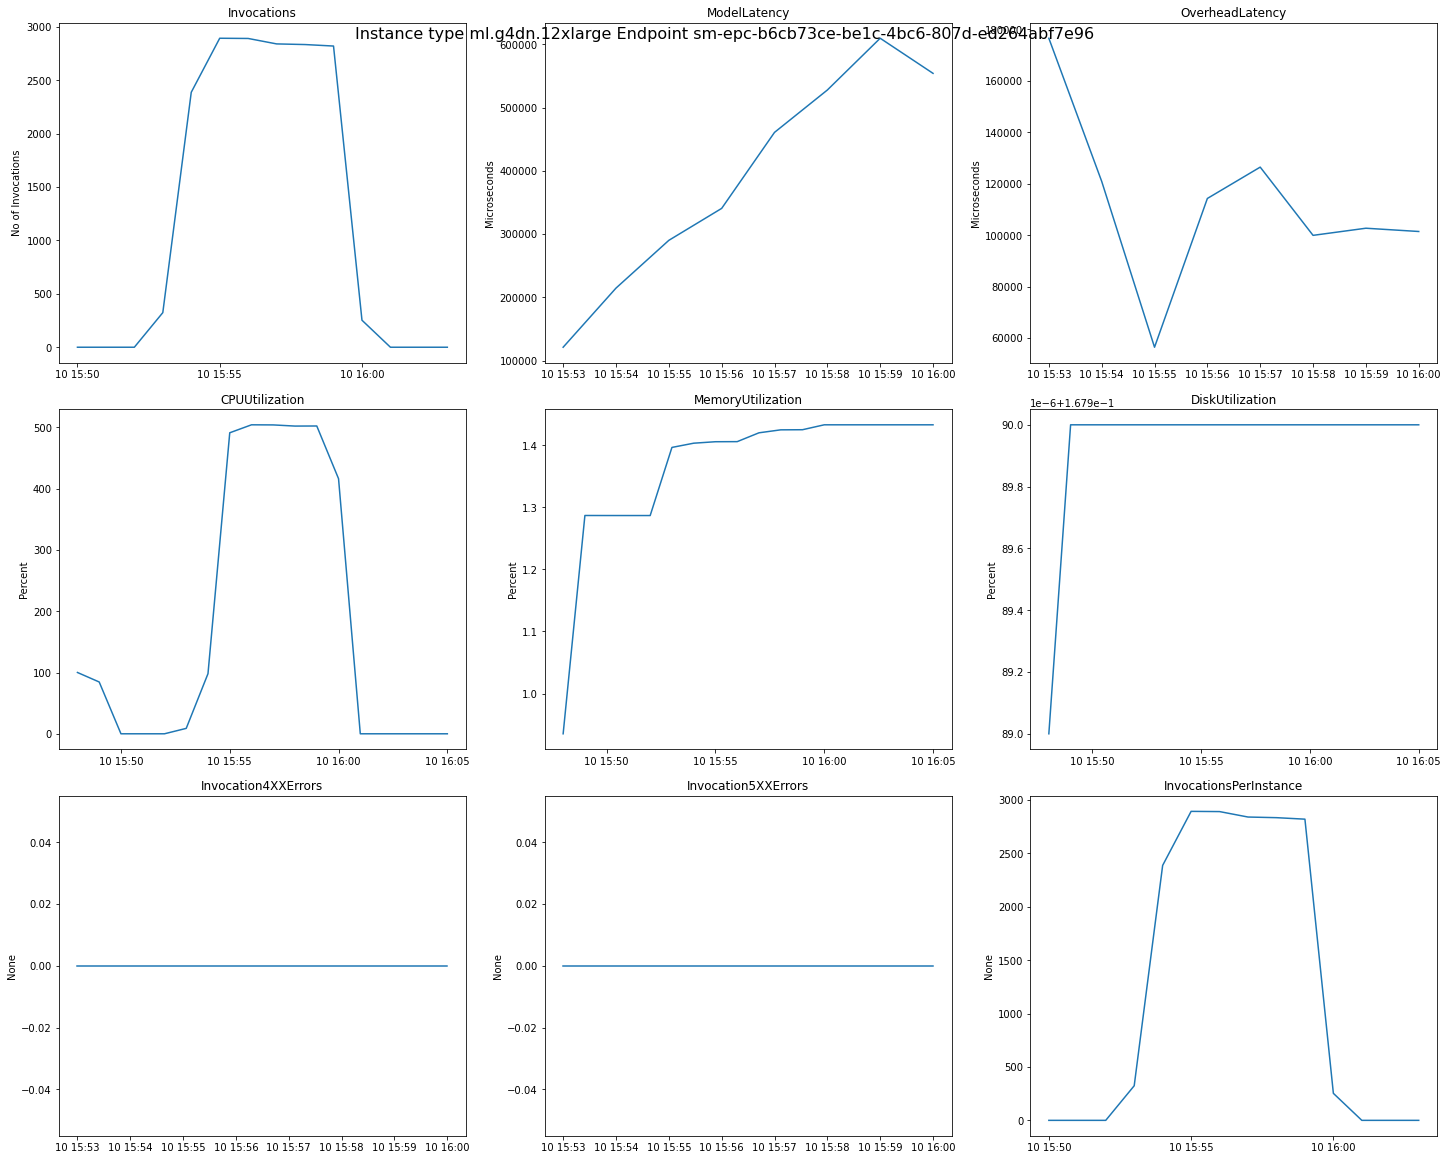

In [19]:
job_name = advanced_response["JobArn"].split("/")[-1]

df_cw = get_endpoint_metrics(sm_client, cw_client, region, job_name, include_plots=True)

In [21]:
data = [
    {**x["EndpointConfiguration"], **x["ModelConfiguration"], **x["Metrics"]}
    for x in inference_recommender_job["InferenceRecommendations"]
]
df = pd.DataFrame(data)
df.drop("VariantName", inplace=True, axis=1)
pd.set_option("max_colwidth", 400)